<a href="https://colab.research.google.com/github/heathlikethecandybar/phase_5/blob/main/phase_5_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Diabetes

#Overview

##Intro - The Cost of Diabetes

According to the International Diabetes Federation, in 2021, an estimated 537 million people worldwide had diabetes, and this number is projected to rise to 642 million by 2040.  This is roughly 1 in 15 people and around 7% of the total population living with Diabetes.  In the United States, the American Diabetes Association reports that the total estimated cost of diagnosed diabetes was $327 billion in 2017, including direct medical costs and reduced productivity.  

Individuals with diabetes tend to have higher healthcare expenses compared to those without the condition. Diabetes also incurs indirect costs, such as lost productivity and disability. These costs arise from missed workdays, reduced productivity at work, early retirement, and disability due to diabetes-related complications.

##Business Problem

An insurance company wants to develop a predictive model to assess the risk of diabetes among their policyholders based on a limited set of available data points. By accurately identifying individuals at high risk of developing diabetes, the company aims to take proactive measures to reduce healthcare costs and improve the overall health outcomes of their customers.

The challenge for the company is to build a robust and accurate predictive model that can handle the complexity and non-linear relationships between the available data points and the risk of developing diabetes. The model will consider factors such as age, gender, BMI, hypertension status, heart disease history, smoking history, HbA1c level, and blood glucose level. We will use a classification model to predict diabetes within the population of interest.

My background and work history has been in healthcare which makes this an interesting problem for me.  Being able to accurately predict risk within a population and provide resources and preventive measures are important now more than ever.

##Evaluation Metrics

To evaluate the different approaches in our classification, we will focus on 2 metrics, `Precision`, and `F1 score`.  Using precision and F1 score as primary metrics in a diabetes classification task is important for several reasons:

Precision focuses on the accuracy of positive predictions, specifically the ratio of true positives to the sum of true positives and false positives.  Maximizing precision helps ensure that the patients identified as positive for diabetes are highly likely to be true positives, reducing the risk of false positives.

F1 score is a balanced metric that considers both precision and recall. By optimizing for F1 score, we are aiming to achieve a balance between correctly identifying positive cases and minimizing false negatives.

In the context of diabetes classification, the consequences of false positives and false negatives can be significant. False positives may lead to unnecessary medical interventions or treatments for patients who are not actually diabetic, causing unnecessary costs and potential harm. False negatives, on the other hand, can result in undiagnosed diabetes cases going untreated, leading to potential health risks and complications. By focusing on precision and F1 score, you aim to strike the right balance between identifying true positive cases and minimizing false predictions, ultimately improving the overall effectiveness of the classification model for diabetes diagnosis.

## About the Data
The Diabetes prediction dataset is a collection of medical and demographic data from patients, along with their diabetes status (positive or negative). The data includes features such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level. This dataset can be used to build machine learning models to predict diabetes in patients based on their medical history and demographic information. This can be useful for healthcare professionals in identifying patients who may be at risk of developing diabetes and in developing personalized treatment plans. Additionally, the dataset can be used by researchers to explore the relationships between various medical and demographic factors and the likelihood of developing diabetes.

Our dataset came from a Kaggle contributor located at this URL (https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset).  We downloaded the data and added to our GitHub repo.


* `gender`- Gender refers to the biological sex of the individual, which can have an impact on their susceptibility to diabetes. There are three categories in it male ,female and other.
* `age` - Age is an important factor as diabetes is more commonly diagnosed in older adults.Age ranges from 0-80 in our dataset.
* `hypertension` - Hypertension is a medical condition in which the blood pressure in the arteries is persistently elevated. It has values a 0 or 1 where 0 indicates they don’t have hypertension and for 1 it means they have hypertension.
* `heart_disease` - Heart disease is another medical condition that is associated with an increased risk of developing diabetes. It has values a 0 or 1 where 0 indicates they don’t have heart disease and for 1 it means they have heart disease.
* `smoking_history` - Smoking history is also considered a risk factor for diabetes and can exacerbate the complications associated with diabetes.In our dataset we have 5 categories i.e not current,former,No Info,current,never and ever.
* `bmi` - BMI (Body Mass Index) is a measure of body fat based on weight and height. Higher BMI values are linked to a higher risk of diabetes. The range of BMI in the dataset is from 10.16 to 71.55. BMI less than 18.5 is underweight, 18.5-24.9 is normal, 25-29.9 is overweight, and 30 or more is obese.
* `HbA1c_level` - HbA1c (Hemoglobin A1c) level is a measure of a person's average blood sugar level over the past 2-3 months. Higher levels indicate a greater risk of developing diabetes. Mostly more than 6.5% of HbA1c Level indicates diabetes.
* `blood_glucose_level` - Blood glucose level refers to the amount of glucose in the bloodstream at a given time. High blood glucose levels are a key indicator of diabetes.
* `diabetes` - Diabetes is the target variable being predicted, with values of 1 indicating the presence of diabetes and 0 indicating the absence of diabetes.

#Data Acquisition

##Importing our packages for EDA

In [2]:
#importing necessary packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
import seaborn as sns
import statsmodels.api as sm
import requests
from zipfile import ZipFile
from io import BytesIO
from tabulate import tabulate

%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.compose import ColumnTransformer,make_column_transformer, make_column_selector
from sklearn.dummy import DummyClassifier
import sklearn.metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, auc
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFECV
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline as ImPipeline


In [3]:
#choosing standard colors for project
pal = sns.color_palette("bone")

color_codes = ['black', 'darkblue', 'blue', 'bluegray', 'bluegreen', 'graygreen']

my_cmap = ListedColormap(sns.color_palette(pal).as_hex())

pal.as_hex()

['#201f2c', '#404059', '#5f657f', '#8091a0', '#9fbcbf', '#cee0df']

##Setting up our data file pull from GitHub

In [4]:
#get the URL of the zip file on GitHub.
url = 'https://github.com/heathlikethecandybar/phase_5/raw/main/data/diabetes-prediction-dataset.zip'

#send a GET request to download the zip file.
response = requests.get(url)

#read the zip file content.
zip_file = ZipFile(BytesIO(response.content))

#extract the CSV file from the zip file.
csv_file = zip_file.namelist()[0]  # assumes only one file in the zip folder


##Importing data

In [131]:
#attaching our csv to a pandas dataframe
df = pd.read_csv(zip_file.open(csv_file))

#Exploratory Data Analysis

In [6]:
#quick look at our data
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [7]:
#loop through each column in the df
for column in df.columns:
    distinct_values = df[column].unique()
    print(f"Column: {column}")
    print(f"Distinct Values: {distinct_values}")
    print("--------------------------")

Column: gender
Distinct Values: ['Female' 'Male' 'Other']
--------------------------
Column: age
Distinct Values: [80.   54.   28.   36.   76.   20.   44.   79.   42.   32.   53.   78.
 67.   15.   37.   40.    5.   69.   72.    4.   30.   45.   43.   50.
 41.   26.   34.   73.   77.   66.   29.   60.   38.    3.   57.   74.
 19.   46.   21.   59.   27.   13.   56.    2.    7.   11.    6.   55.
  9.   62.   47.   12.   68.   75.   22.   58.   18.   24.   17.   25.
  0.08 33.   16.   61.   31.    8.   49.   39.   65.   14.   70.    0.56
 48.   51.   71.    0.88 64.   63.   52.    0.16 10.   35.   23.    0.64
  1.16  1.64  0.72  1.88  1.32  0.8   1.24  1.    1.8   0.48  1.56  1.08
  0.24  1.4   0.4   0.32  1.72  1.48]
--------------------------
Column: hypertension
Distinct Values: [0 1]
--------------------------
Column: heart_disease
Distinct Values: [1 0]
--------------------------
Column: smoking_history
Distinct Values: ['never' 'No Info' 'current' 'former' 'ever' 'not current']
---

Looks like we will have 7 independent variables, and 1 dependent variable (target) which is our diabetes column.  Hypertension, heart disease, and smoking history are categorical values.  In which we may need to one encode.

In [8]:
#taking a look at our data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [9]:
#look for missing records
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

No missing records which is good.  100k records, which is a good sized data set.  I wish there was more interesting columns, however, these are the core tenants for predicting diabetes.

In [10]:
#summary stats
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


Roughly 8.5% of the population in this dataset has been diagnosed with Diabetes.  It wasn't explicitly stated, but based ont this number, I am assuming that this is based on type 2 diabetes diagnoses.  Average age is 42 years of age, roughly 7.5% of the population has been diagnosed with hypertension, and 4% diagnosed with heart disease.  The average Body Mass Index (BMI) is 27, which is considered overweight.  The blood glucose level is 138 and HbA1c level is 5.5 on average.  For non-diabetics, the normal HbA1c level ranges between 4% and 5.6%. Levels between 5.7% and 6.4% indicate prediabetes and a greater possibility of diabetes. HbA1c of 6.5% or greater indicates diabetes.  Also looks like we have some weird decimals for our ages.  I am going to round those down to the nearest whole number.

In [11]:
#rounding down the age to nearest whole number and adjusting data type to int
df.loc[:, 'age'] = np.floor(df.loc[:, 'age']).astype(int);

<ipython-input-11-aff4eeaa9027>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'age'] = np.floor(df.loc[:, 'age']).astype(int);


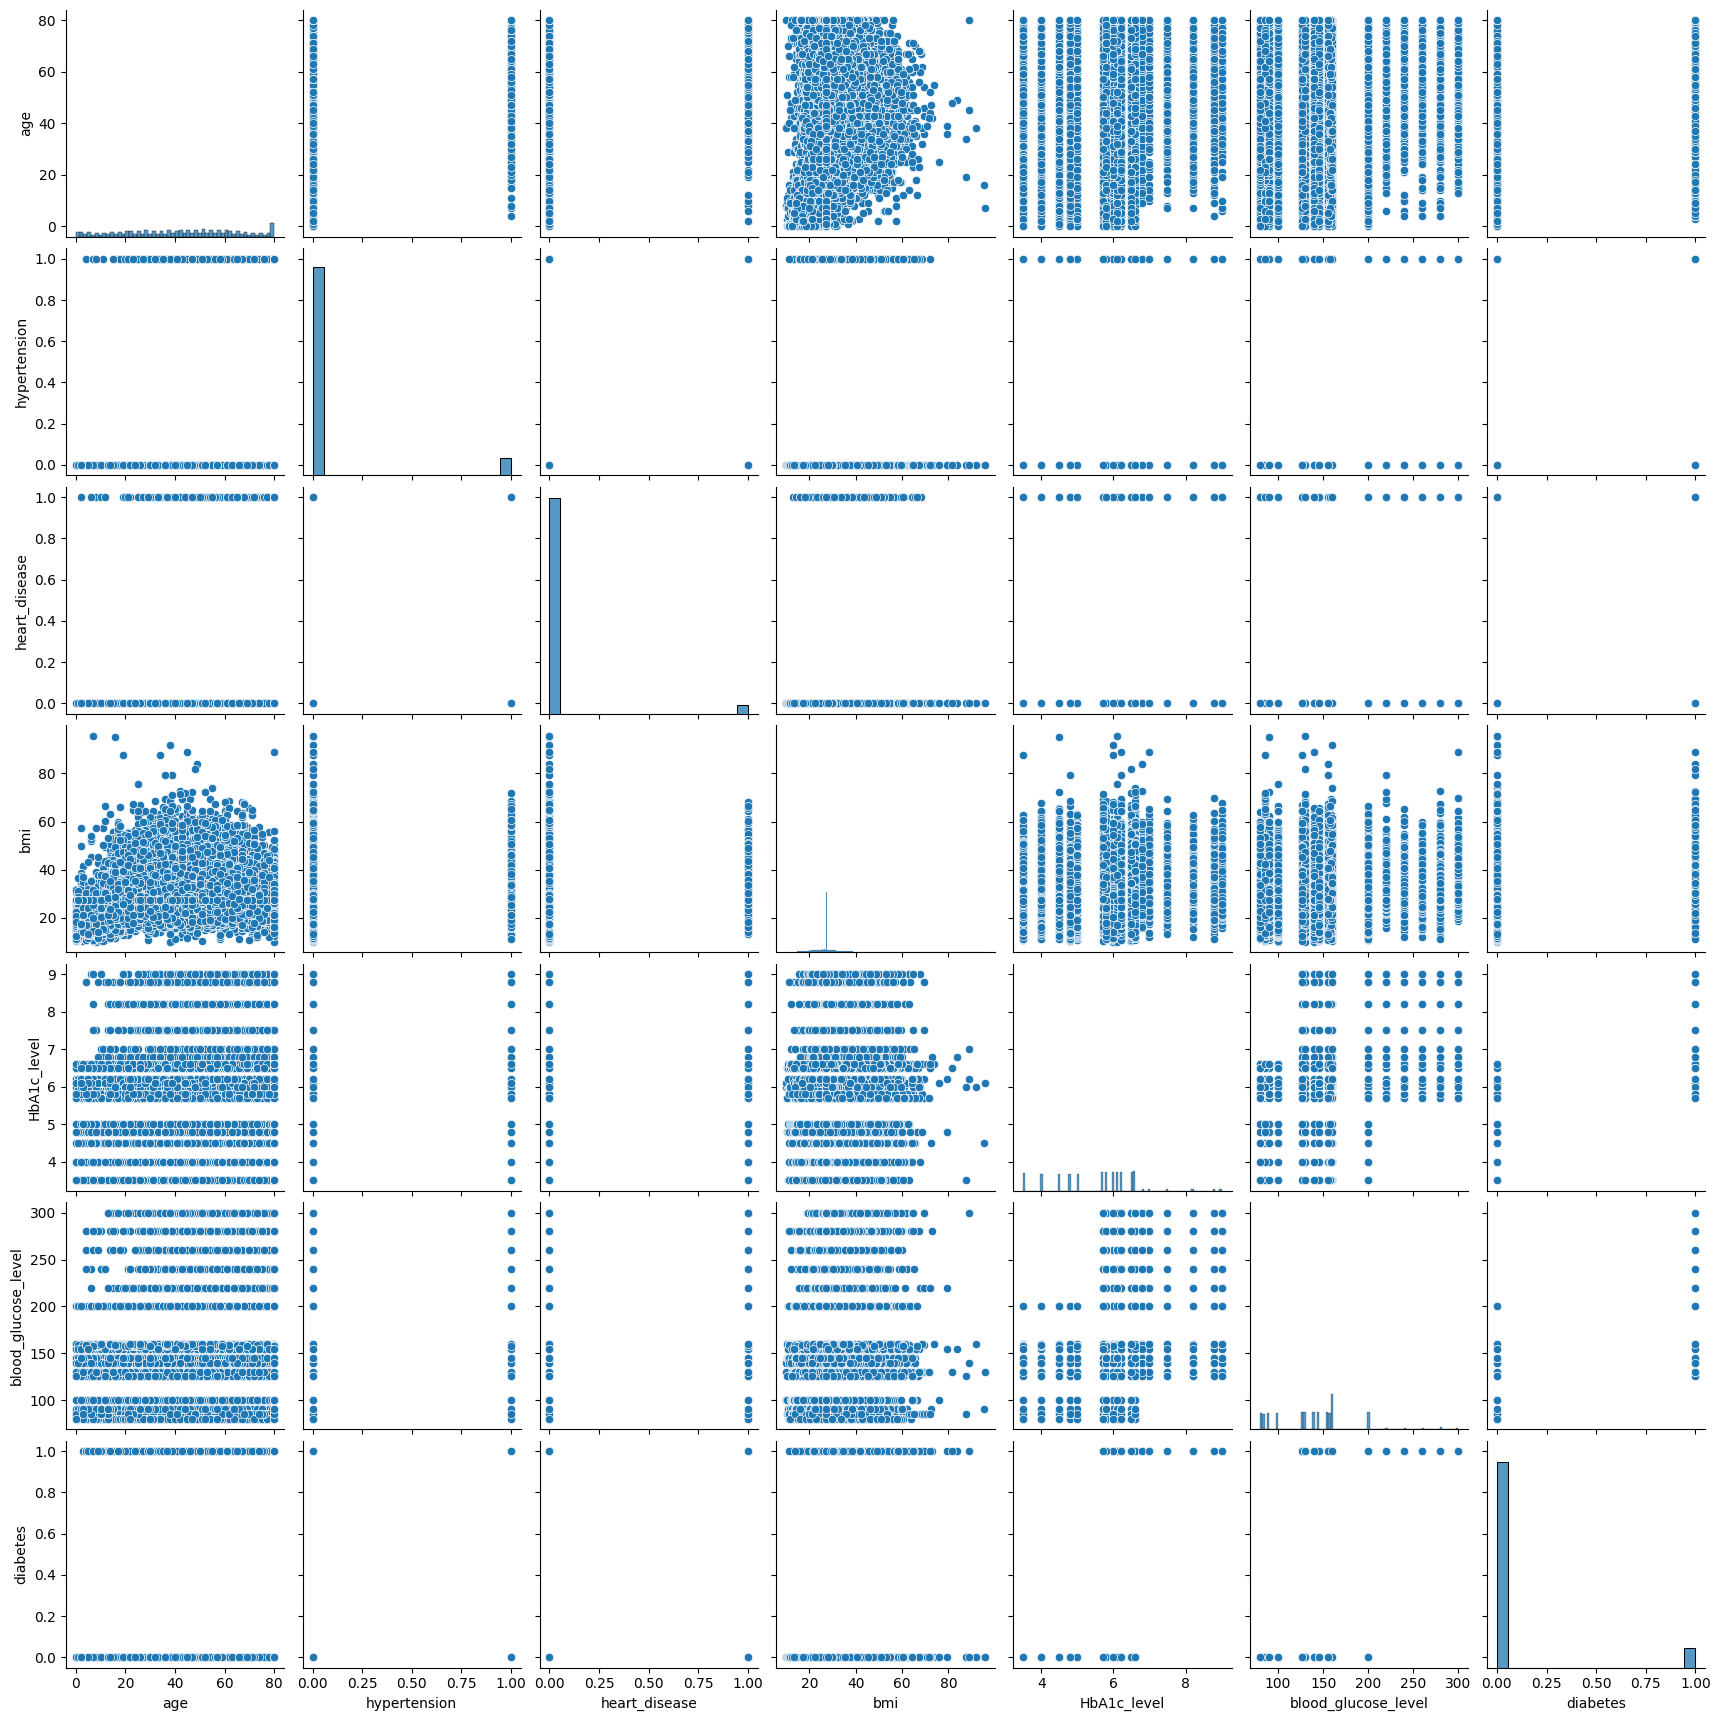

In [12]:
#create the pair plot to look at distributions
sns.pairplot(df);

Looks like our target is imbalanced, so we will most likely be using an oversampling method such as smote to deal with the imbalance.  This seems to be the case even with some of our independent variables.  Which makes sense when you think about the distribution of the population with heart disease, hypertension, and diabetes.

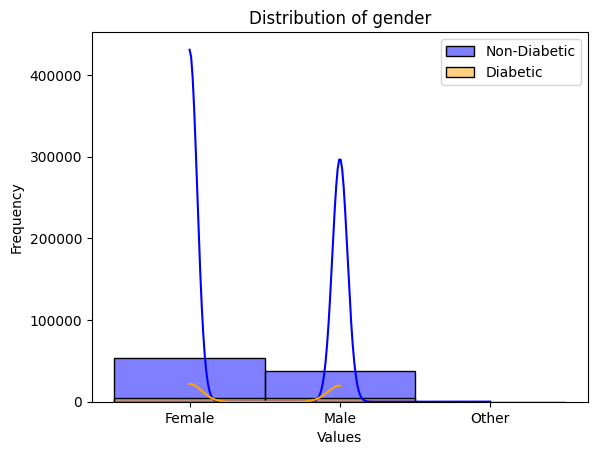

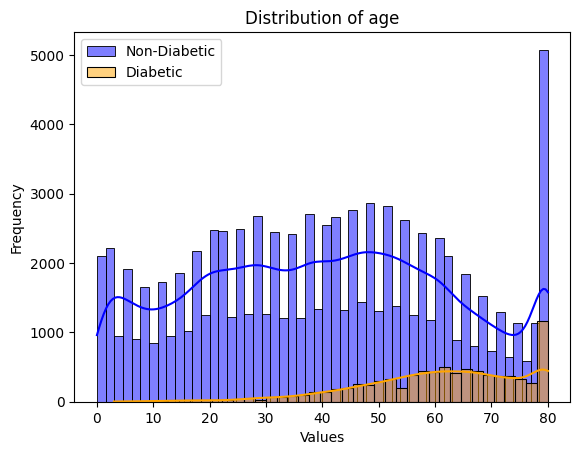

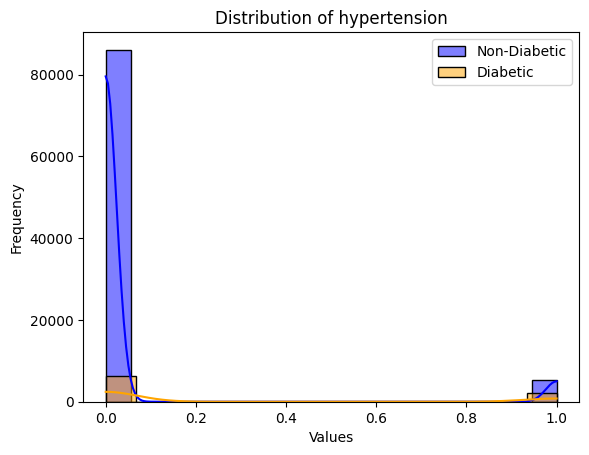

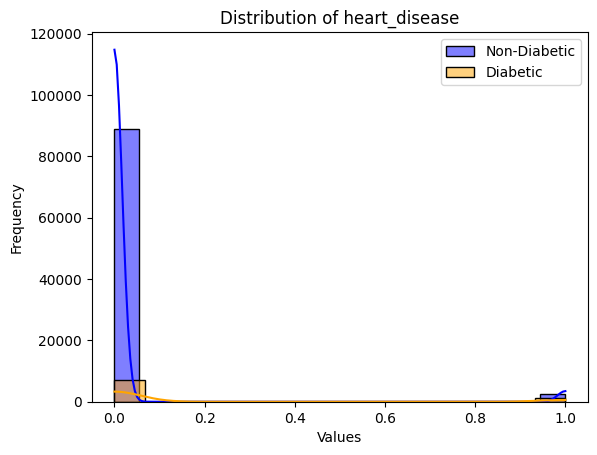

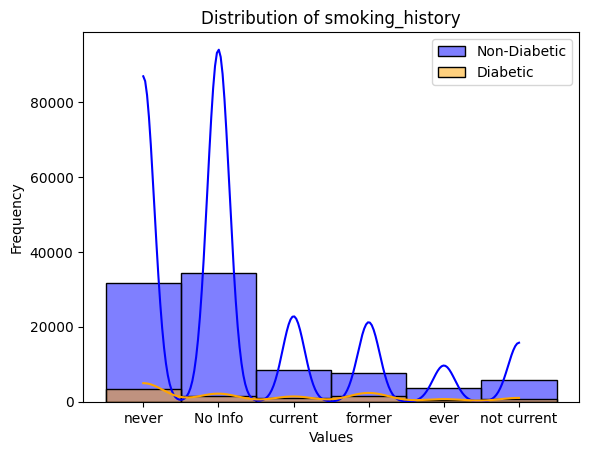

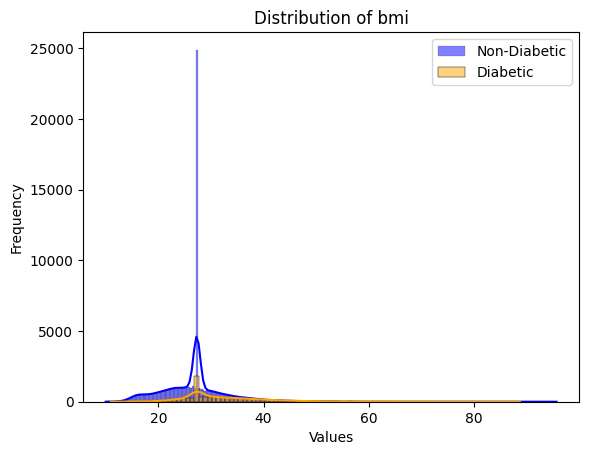

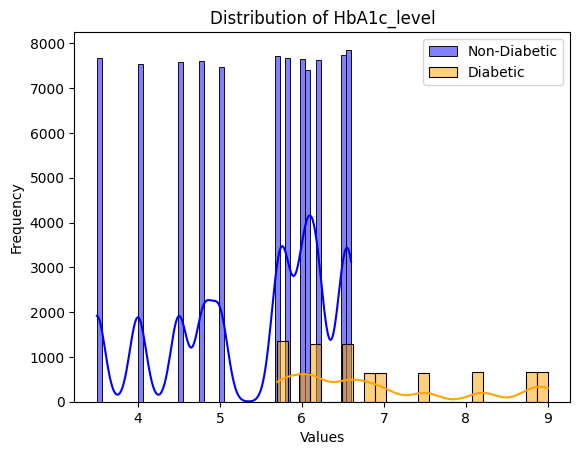

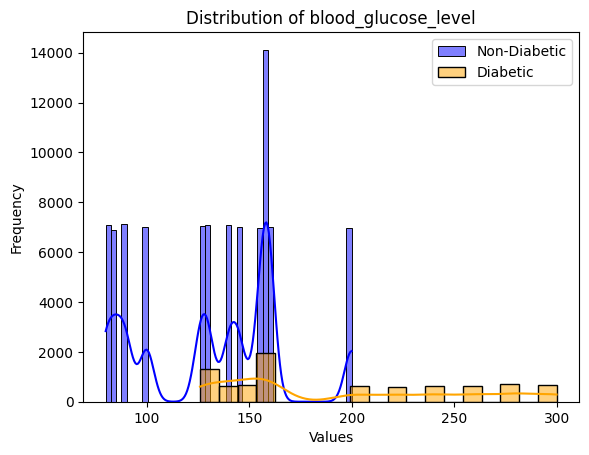

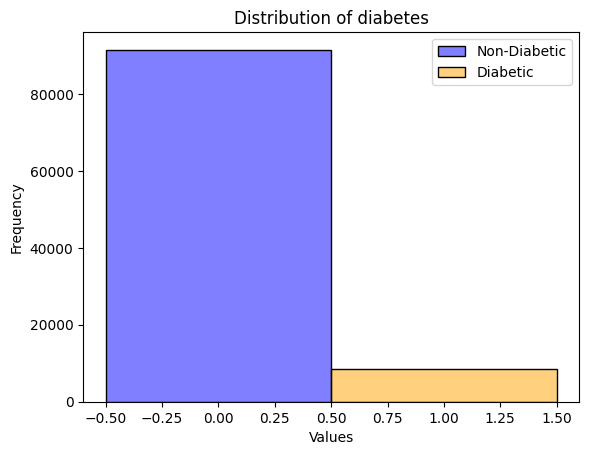

In [13]:
#get the list of column names
columns = df.columns

#create individual distribution plots for each column based on the binary column
for column in columns:
    plt.figure()
    sns.histplot(df[df['diabetes'] == 0][column], kde=True, color='blue', label='Non-Diabetic')
    sns.histplot(df[df['diabetes'] == 1][column], kde=True, color='orange', label='Diabetic')
    plt.title(f'Distribution of {column}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
plt.show()

These displays further display our insights from above in our quick statistical analysis of the data.  This shows the distribution between diabetics and non-diabetics more clearly.  For instnace blood glucose levels for diabetics typically never go below 130.  Or HbA1c levels typically don't dip below roughly 5.8%.  BMI Has a major outlier that we will want to remove or impute.  And age shows the skew towards older ages more likely diagnosed starting around mid 30s.

In [14]:
#creating a function to make charting easier as I move through the different categories.  Some of these visuals will be duplicative of the charting above.
def mini_bar(x, y, x_title, y_title, plot_title):
    mean_df = df[[x, y]].groupby(x, as_index=False).mean()
    count_df = df[x].value_counts().reset_index()
    count_df.columns = [x, 'Count']

    mean_df = mean_df.merge(count_df, on=x)

    print(mean_df)

    #bar plot to visualize
    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax1 = sns.barplot(x=x, y=y, data=mean_df, ax=ax1)
    ax1.set_ylabel(y_title)
    ax1.set_xlabel(x_title)
    ax1.set_title(plot_title)
    plt.xticks(rotation='vertical')

    #define the percentage formatter function
    def percent_formatter(x, pos):
        return f'{x * 100:.0f}%'

    #set the y-axis formatter
    formatter = mtick.FuncFormatter(percent_formatter)
    ax1.yaxis.set_major_formatter(formatter)

    #add a second axis for the count
    ax2 = ax1.twinx()
    ax2.plot(count_df[x], count_df['Count'], color='gray', marker='o', linestyle='', markersize=8)
    ax2.set_ylabel('# of Cases')

    #display the plot
    plt.show()

   gender  diabetes  Count
0  Female  0.076189  58552
1    Male  0.097490  41430
2   Other  0.000000     18


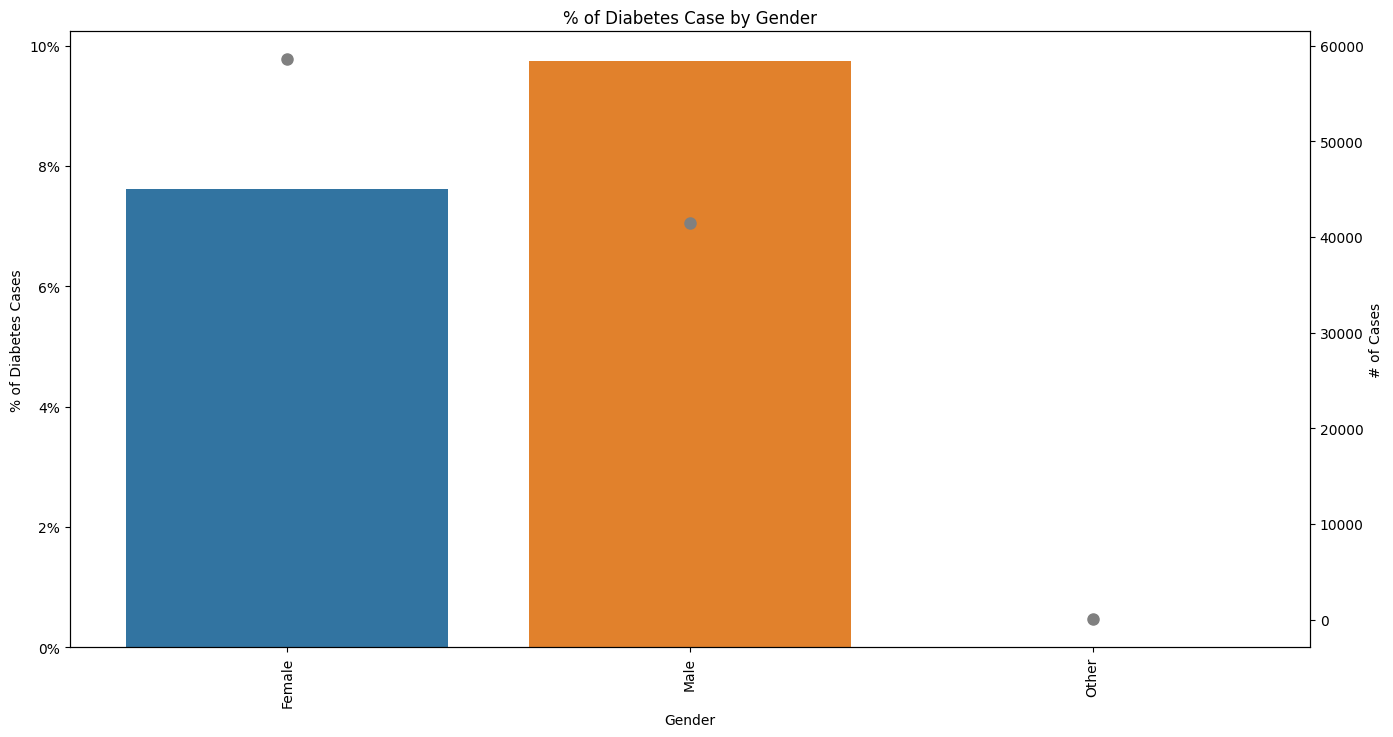

In [15]:
#visualizing the relationship
mini_bar('gender', 'diabetes', 'Gender', '% of Diabetes Cases', '% of Diabetes Case by Gender')

Males typically have a higher prevalence of diabetes than femals, and vs other genders.  According to one source, men have had slightly higher rates of diabetes than women. However, the difference in prevalence between genders is not substantial.

    age  diabetes  Count
0     0  0.000000    911
1     1  0.000000   1190
2     2  0.000000   1186
3     3  0.000963   1038
4     4  0.006296    953
..  ...       ...    ...
76   76  0.203274    733
77   77  0.186301    730
78   78  0.199413    682
79   79  0.227053    621
80   80  0.182174   5621

[81 rows x 3 columns]


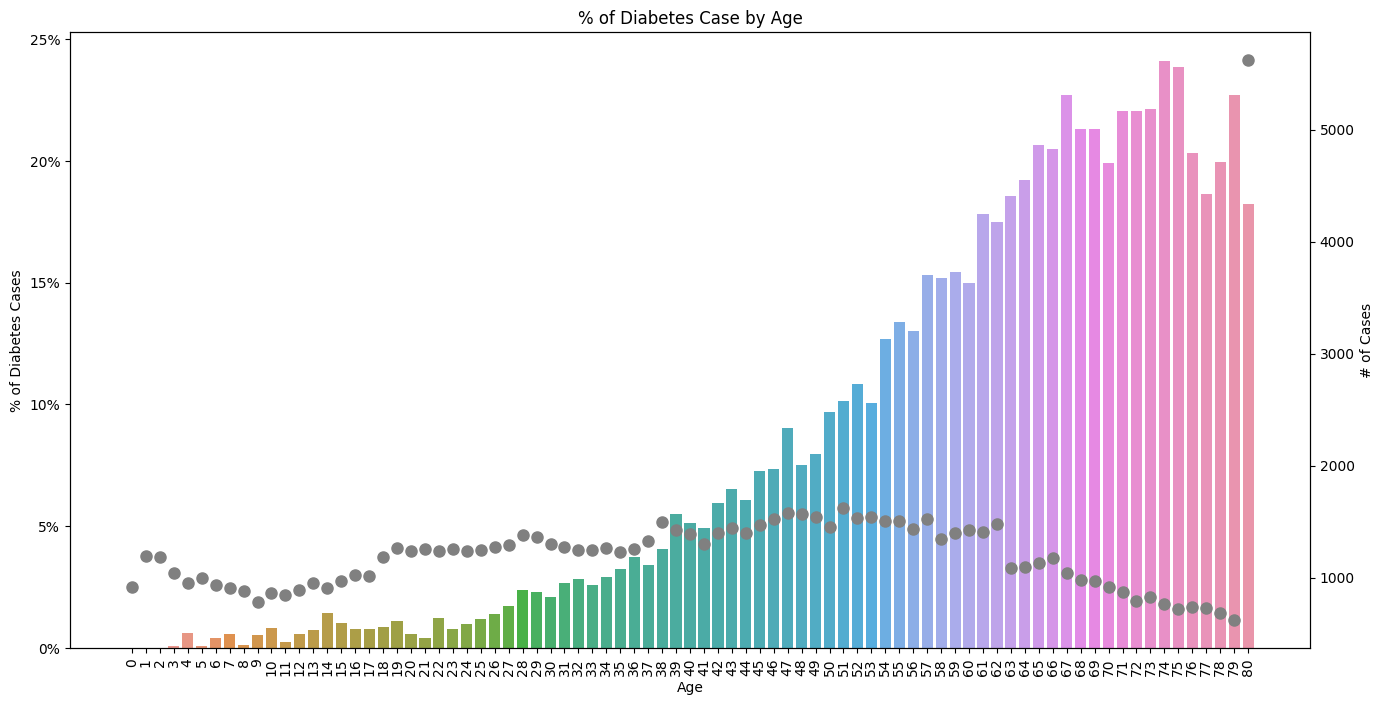

In [16]:
# Visualizing the relationship

mini_bar('age', 'diabetes', 'Age', '% of Diabetes Cases', '% of Diabetes Case by Age');

This distbrition of prevalence by age shows us the increasing diabetest prevlance as age increases.  This rings true with a lot of the studies that exist as the risk for other diabetes based risk factors also increase with age (i.e. heart disease, hypertension, obesity)

   hypertension  diabetes  Count
0             0  0.069308  92515
1             1  0.278958   7485


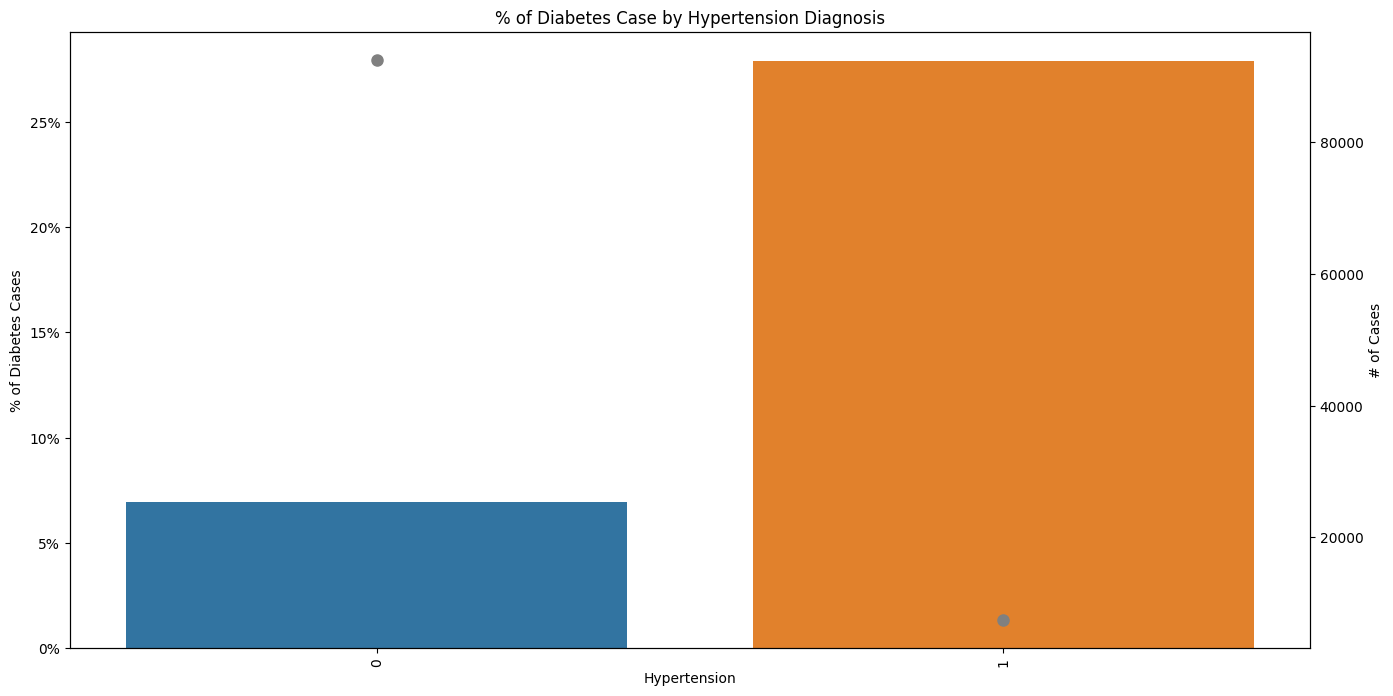

In [17]:
mini_bar('hypertension', 'diabetes', 'Hypertension', '% of Diabetes Cases', '% of Diabetes Case by Hypertension Diagnosis')

Hypertension (high blood pressure) and diabetes have a bidirectional relationship. They can worsen each other and increase the risk of cardiovascular complications. Hypertension can make it harder to control blood sugar levels, contribute to kidney damage, worsen diabetic retinopathy, and impact other organs. Managing both conditions through lifestyle changes and medications is crucial for overall health.

   heart_disease  diabetes  Count
0              0  0.075298  96058
1              1  0.321410   3942


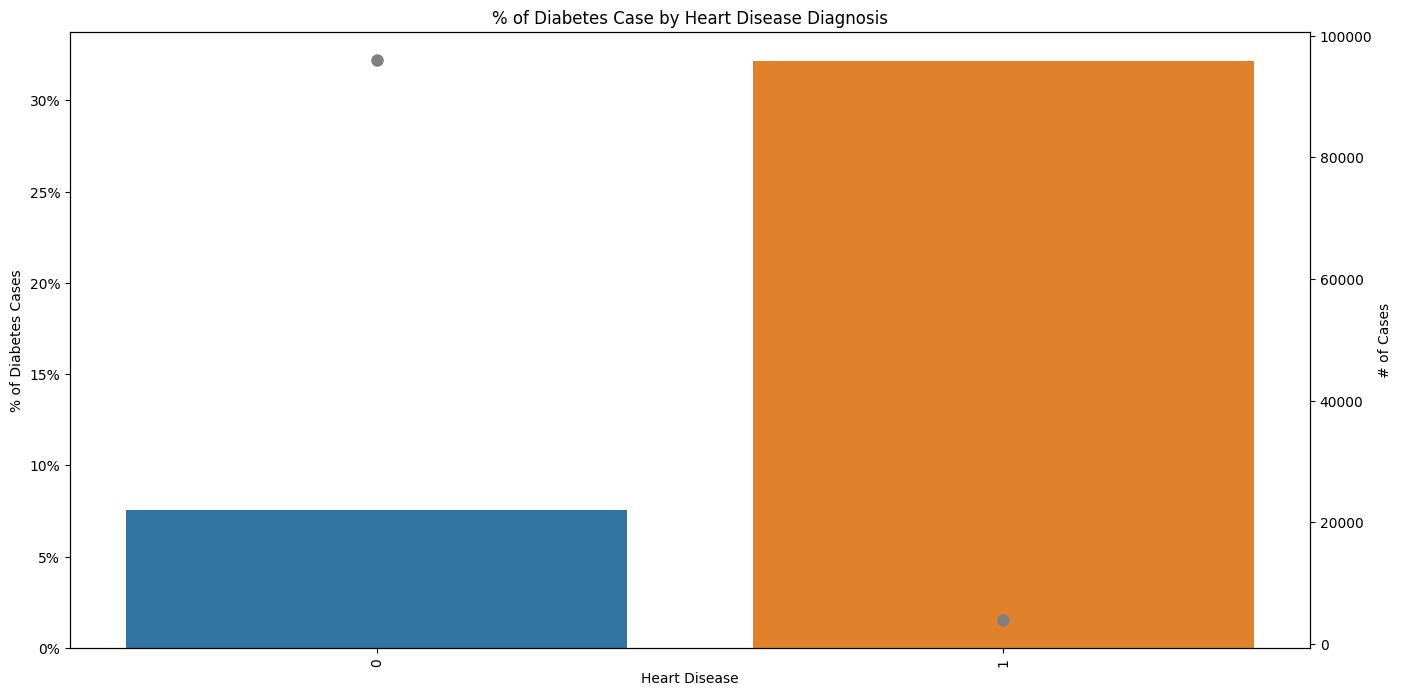

In [18]:
mini_bar('heart_disease', 'diabetes', 'Heart Disease', '% of Diabetes Cases', '% of Diabetes Case by Heart Disease Diagnosis')

Heart disease is a significant and interconnected complication of diabetes. Individuals with diabetes have an increased risk of developing heart conditions such as coronary artery disease, heart attacks, and heart failure. The presence of diabetes can accelerate the progression and severity of heart disease due to factors such as high blood sugar levels, insulin resistance, inflammation, and abnormal blood lipid levels. Shared risk factors like obesity, high blood pressure, and unhealthy cholesterol levels further contribute to the link between diabetes and heart disease.

  smoking_history  diabetes  Count
0         No Info  0.040596  35816
1         current  0.102089   9286
2            ever  0.117882   4004
3          former  0.170017   9352
4           never  0.095341  35095
5     not current  0.107027   6447


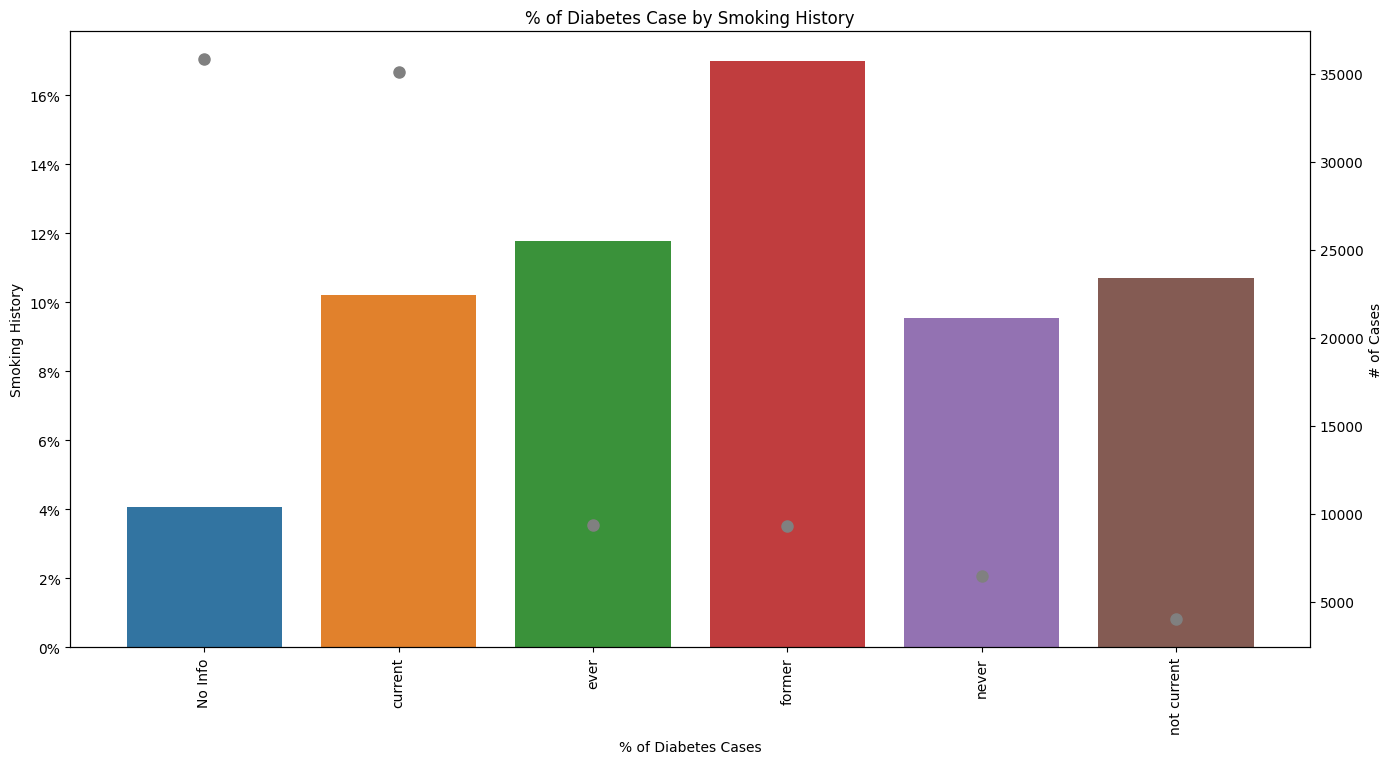

In [19]:
mini_bar('smoking_history', 'diabetes', '% of Diabetes Cases', 'Smoking History', '% of Diabetes Case by Smoking History')

The impact of smoking history on diabetes is significant. Research has shown that smoking increases the risk of developing type 2 diabetes. Smoking impairs insulin sensitivity and glucose metabolism, making it harder for the body to regulate blood sugar levels effectively. Additionally, smoking exacerbates other diabetes-related complications, such as cardiovascular disease, kidney disease, and nerve damage. Quitting smoking can greatly reduce the risk of developing diabetes and improve overall health outcomes for individuals with diabetes. It is crucial for individuals with diabetes to avoid smoking and for those who smoke to quit in order to better manage their condition and reduce associated health risks.

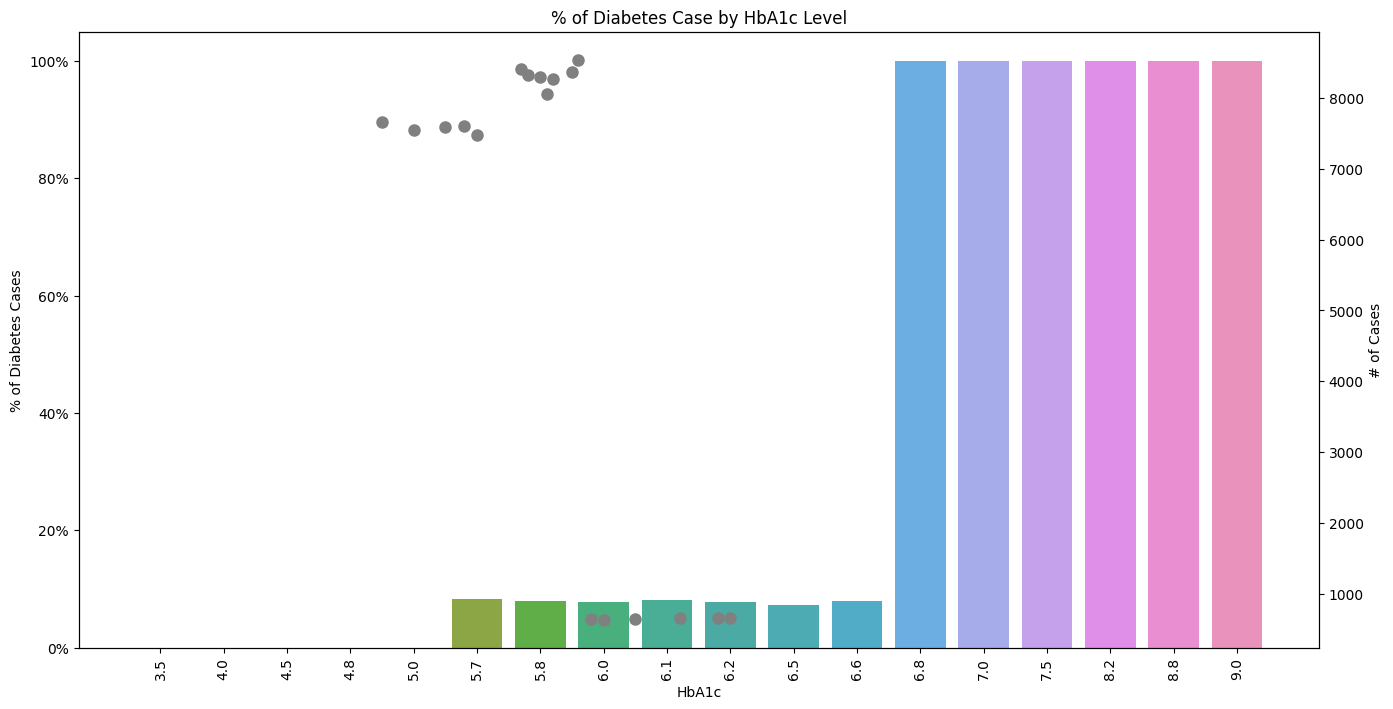

In [21]:
mini_bar('HbA1c_level', 'diabetes', 'HbA1c', '% of Diabetes Cases', '% of Diabetes Case by HbA1c Level')

HbA1c, or glycated hemoglobin, is a vital indicator in the management of diabetes. It measures the average blood sugar levels over a span of two to three months. Maintaining a target HbA1c level is crucial for individuals with diabetes as it reflects their overall blood glucose control. High HbA1c levels indicate poor diabetes management and an increased risk of diabetes-related complications. It is important to keep HbA1c within the recommended target range, as defined by healthcare professionals, to reduce the risk of long-term complications such as heart disease, kidney damage, nerve damage, and eye problems. Regular monitoring of HbA1c and adjustments to treatment plans, including medication, diet, and exercise, are essential for individuals with diabetes to achieve optimal blood sugar control and maintain good overall health.

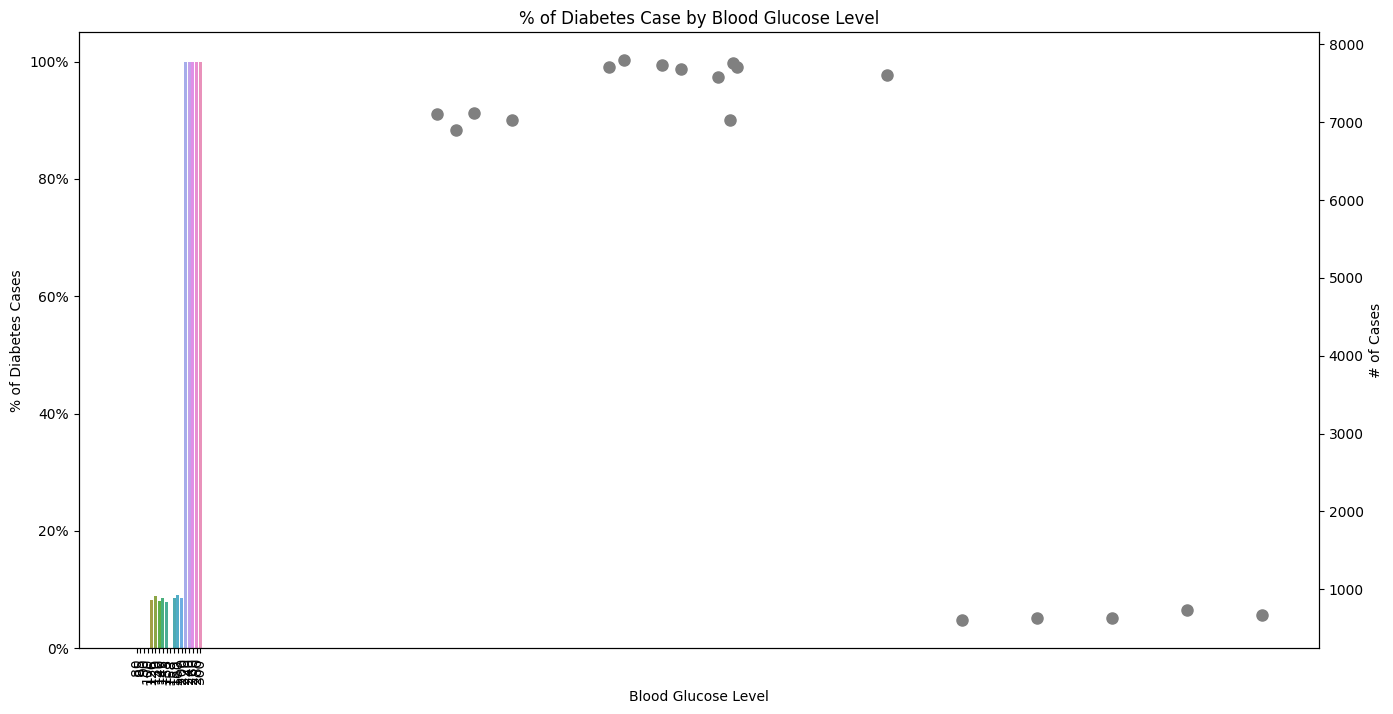

In [22]:
mini_bar('blood_glucose_level', 'diabetes', 'Blood Glucose Level', '% of Diabetes Cases', '% of Diabetes Case by Blood Glucose Level')

** Need insight here; also need to think about potentially removing blood glucose and HbA1c level from the data.  This is essentially another indicator for diabetes since such few cases under the thresholds can have diabetes, but over the threshold "guarantees" a diagnosis.

<ipython-input-23-7aed80630166>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


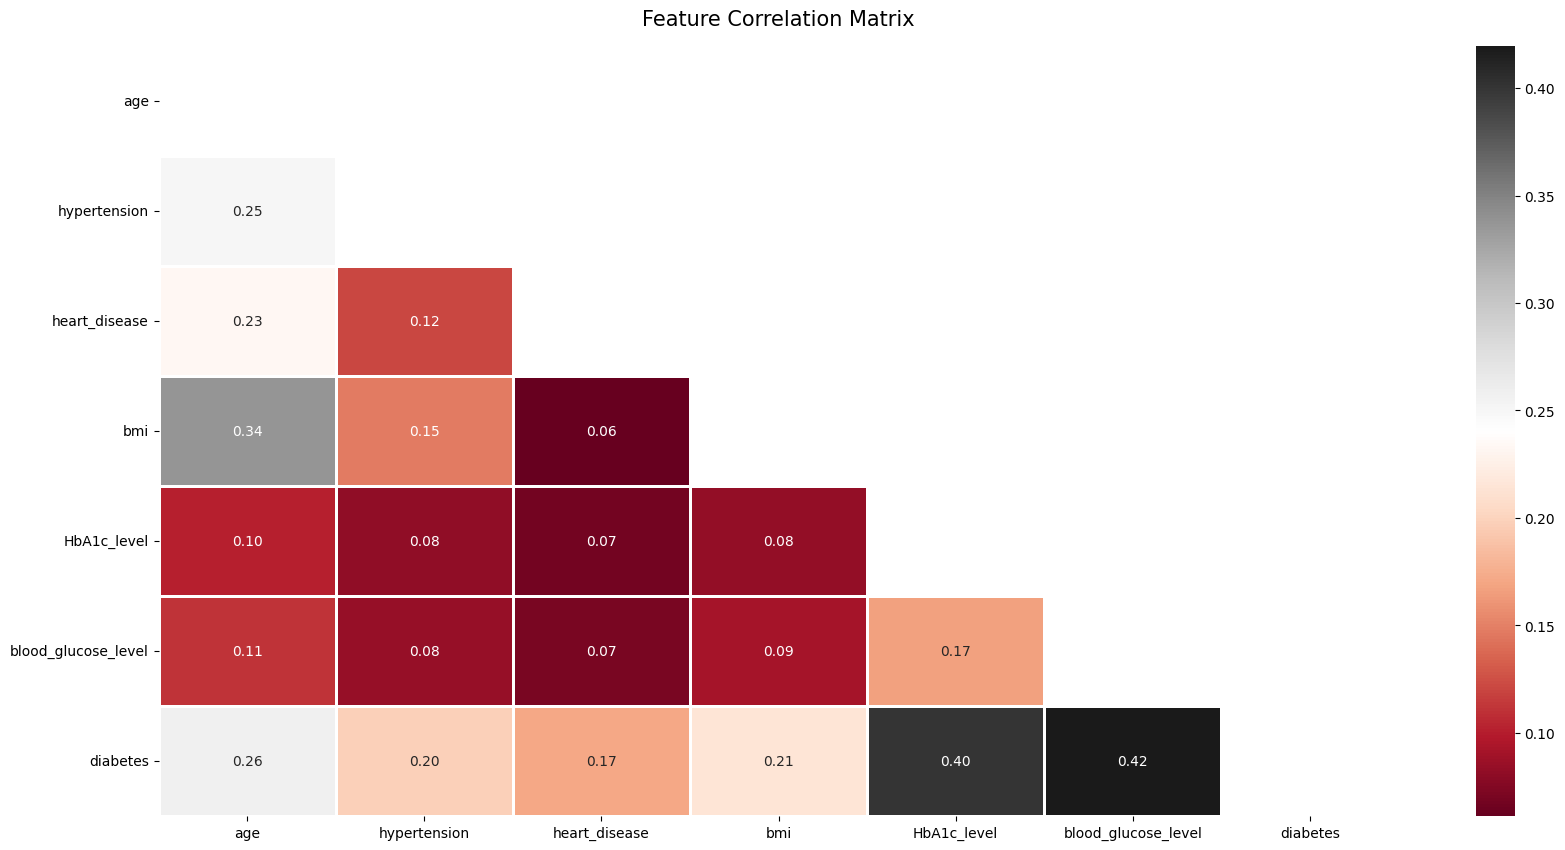

In [23]:
#creating a heatmap to look at colinearity and potential categories that will lead to churn prediction.

corr = df.corr()

fix, ax = plt.subplots(figsize = (20,10))
matrix = np.triu(corr)
ax.set_title('Feature Correlation Matrix', pad=15, fontsize=15)
heatmap = sns.heatmap(corr, annot=True, cmap='RdGy', fmt='.2f', mask=matrix, linewidths=1)
plt.show();

As we were seeing in our EDA there is a high correlation bewteen HbA1c and blood glucose levels within diabetes cases.  Age is the 3rd highest correlated value, while BMI, hypertension and heart disease also show moderate correlations.  We also see a high correlation between age and BMI which makes sense, and hypertension and heart disease.

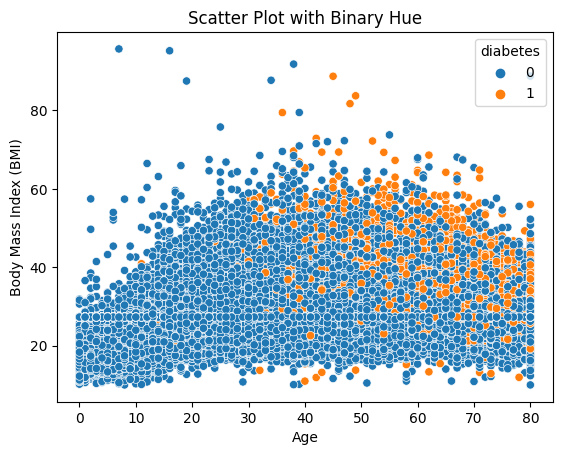

In [24]:
#create the scatter plot
sns.scatterplot(x=df['age'], y=df['bmi'], hue=df['diabetes'])

#set labels and title
plt.xlabel('Age')
plt.ylabel('Body Mass Index (BMI)')
plt.title('Scatter Plot with Binary Hue')

#display the plot
plt.show()

Not a super helpful chart but further shows the impact of age on diabetes.  Again the combination of co-morbid factors, along with risk, ultimately leads to the diagnosis of diabetes.

# Classification Modelling

##Additional Cleaning

In [132]:
#because HbA1c & Blood Glucose levels are so highly correlated with the diagnosis of Diabetes, I am going to initially remove this from our modeling.
df_clean = df
df_clean.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [133]:
df_clean['gender'].value_counts()

Female    58552
Male      41430
Other        18
Name: gender, dtype: int64

In [134]:
df_clean = df[df['gender'] != 'Other']

In [135]:
df_clean['gender'].value_counts()

Female    58552
Male      41430
Name: gender, dtype: int64

In [136]:
#convert the categorical column to numeric using one-hot encoding
df_encoded = pd.get_dummies(df_clean, columns=['gender', 'smoking_history'], drop_first=True)
df_encoded.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,0,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,1,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,1,1,0,0,0,0


In [137]:
#situate target and non-target features

X = df_encoded.drop(['diabetes'], axis=1)
y = df_encoded['diabetes']

#create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [138]:
#also looking at a dummy model with 5 cross validation folds.  Mean accuracy is about
#92%.  This aligns with our assumption above with the imbalance of our churned
#customer count.

dummy_model = DummyClassifier(strategy='most_frequent')

cv_results = cross_val_score(dummy_model,
                             X_train,
                             y_train,
                             cv=5)

dummy_model.fit(X_train, y_train)

np.mean(cv_results)

0.9158642947863254

A dummy model with the strategy of predicting the most frequent class achieves an average accuracy of around 92% across five cross-validation folds.

This high accuracy can be attributed to the imbalance in the target variable, where the majority class (patients without a diabetes diagnosis) dominates the dataset. Since the dummy model always predicts the most frequent class, it will correctly predict the majority class most of the time, leading to a high accuracy score.

In this case, the high accuracy of the dummy model does not necessarily indicate a good predictive performance. It simply reflects the class imbalance in the dataset.

We will be using precision and f1 score to evaluate our models below.  Precision measures the proportion of positive predictions that are actually correct.  Therefore minimizing the false positives in our models.

##Pipeline

In [32]:
#labeling columns for different preprocessing steps

categorical_columns = []

numerical_columns = ['age',
                     'bmi',
                     'HbA1c_level',
                     'blood_glucose_level'
                    ]

binary_columns = ['hypertension',
                  'heart_disease',
                  'smoking_history_current',
                  'smoking_history_ever',
                  'smoking_history_former',
                  'smoking_history_never',
                  'smoking_history_not current',
                  'gender_Male'
                  ]

In [33]:
#check to make sure we have all our columns accounted for
(len(categorical_columns)+len(numerical_columns)+len(binary_columns)) == (df_encoded.shape[1]-1)

True

In [34]:
#saving a copy of our data frame to reference columns later.
df_X_train_copy = X_train.iloc[:10]

df_X_test_copy = X_test.iloc[:10]

In [35]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99982 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          99982 non-null  int64  
 1   hypertension                 99982 non-null  int64  
 2   heart_disease                99982 non-null  int64  
 3   bmi                          99982 non-null  float64
 4   HbA1c_level                  99982 non-null  float64
 5   blood_glucose_level          99982 non-null  int64  
 6   diabetes                     99982 non-null  int64  
 7   gender_Male                  99982 non-null  uint8  
 8   smoking_history_current      99982 non-null  uint8  
 9   smoking_history_ever         99982 non-null  uint8  
 10  smoking_history_former       99982 non-null  uint8  
 11  smoking_history_never        99982 non-null  uint8  
 12  smoking_history_not current  99982 non-null  uint8  
dtypes: float64(2), i

##Logistic Regression

###Baseline Logistic Regression

In [36]:
#baseline Logistic Regression model
baseline_logreg = ImPipeline(steps=[('sm', SMOTE(random_state=42)),
                                    ('scale', StandardScaler()),
                                    ('estimator', LogisticRegression(random_state=42))])

#train model
baseline_logreg.fit(X_train, y_train);

In [38]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
baseline_logreg_roc_score_train = roc_auc_score(y_train, baseline_logreg.predict(X_train))
baseline_logreg_roc_score_test = roc_auc_score(y_test, baseline_logreg.predict(X_test))

#capture precision scores for test and train
#baseline_logreg_precision_score_train_cv = cross_val_score(estimator=baseline_logreg, X=X_train,  y=y_train,
#                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

baseline_logreg_precision_score_train = precision_score(y_train, baseline_logreg.predict(X_train))
baseline_logreg_precision_score_test = precision_score(y_test, baseline_logreg.predict(X_test))

#capture f1 scores for test and train
baseline_logreg_f1_score_train = f1_score(y_train, baseline_logreg.predict(X_train))
baseline_logreg_f1_score_test = f1_score(y_test, baseline_logreg.predict(X_test))

#capture recall scores for test and train
baseline_logreg_recall_score_train = recall_score(y_train, baseline_logreg.predict(X_train))
baseline_logreg_recall_score_test = recall_score(y_test, baseline_logreg.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {baseline_logreg_roc_score_train :.2%}")
print(f" Test ROC Score: {baseline_logreg_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {baseline_logreg_precision_score_train :.2%}")
print(f" Test Precision score: {baseline_logreg_precision_score_test :.2%}")
#print(f" Mean Cross Validated Precision Score: {baseline_logreg_precision_score_train_cv :.2%}")
print(divider)

print(f" Train F1 score: {baseline_logreg_recall_score_train :.2%}")
print(f" Test F1 score: {baseline_logreg_recall_score_test :.2%}")
print(divider)

print(f" Train Recall score: {baseline_logreg_f1_score_train :.2%}")
print(f" Test Recall score: {baseline_logreg_f1_score_test :.2%}")
print(divider, '\n')


 Performance Comparison 

--------------------------------------------------
 Train ROC Score: 85.06%
 Test ROC Score: 85.04%
--------------------------------------------------
 Train Precision score: 41.94%
 Test Precision score: 43.22%
--------------------------------------------------
 Train F1 score: 80.33%
 Test F1 score: 80.19%
--------------------------------------------------
 Train Recall score: 55.11%
 Test Recall score: 56.17%
-------------------------------------------------- 



An ROC score of 85.06% on the training set and 85.04% on the test set suggests that the model has good discrimination power in distinguishing between diabetic and non-diabetic cases. The recall score of 55.11% on the training set and 56.17% on the test set indicates that the model can capture around 56% of the true positive cases. The F1 score of 80.33% on the training set and 80.19% on the test set indicates that the model achieves a reasonable trade-off between precision and recall. The Precision score of 41.94% on the training set and 43.22% on the test set suggests that when the model predicts a positive case, it is correct approximately 42% of the time. Overall, the scores indicate that the model performs reasonably well in predicting diabetes diagnosis. However, there is room for improvement in precision, which represents the accuracy of positive predictions.

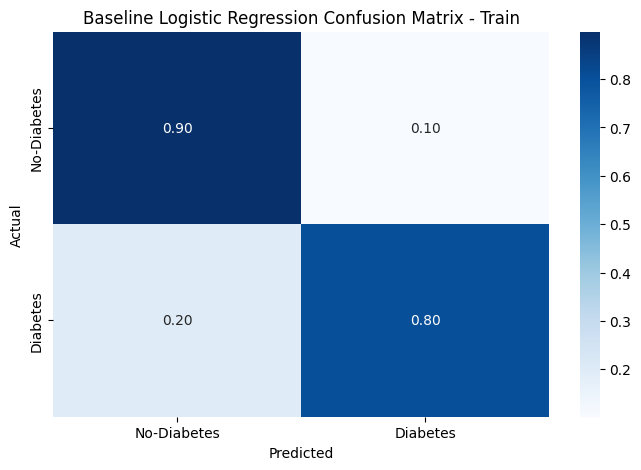

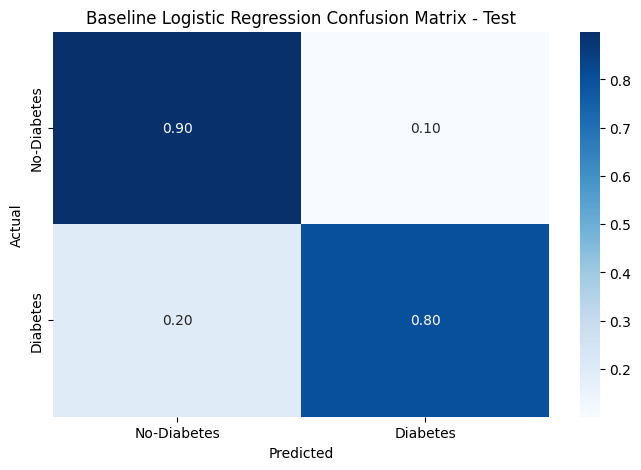

In [39]:
#define the labels for the confusion matrix
labels = ['No-Diabetes', 'Diabetes']

#compute the confusion matrix for the baseline logistic regression - Train
train_pred = baseline_logreg.predict(X_train)
train_cm = confusion_matrix(y_train, train_pred, normalize='true')

#plotting confusion matrix for the baseline logistic regression - Train
plt.figure(figsize=(8, 5))
sns.heatmap(train_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline Logistic Regression Confusion Matrix - Train")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

#compute the confusion matrix for the baseline logistic regression - Test
test_pred = baseline_logreg.predict(X_test)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

#plotting confusion matrix for the baseline logistic regression - Test
plt.figure(figsize=(8, 5))
sns.heatmap(test_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline Logistic Regression Confusion Matrix - Test")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()


Again for our first model and baseline test, the model is performing generally well.  The model achieved a high percentage (90%) of correctly identified positive cases, which indicates a good sensitivity or recall rate. It correctly identified a large proportion of the diabetic patients in the dataset.

The model had a low percentage (10%) of false positive predictions, indicating a good specificity. It made relatively fewer incorrect positive predictions compared to the total number of actual negative cases.

The model had a higher percentage (20%) of false negative predictions, suggesting that it missed a significant number of actual positive cases. This indicates a lower sensitivity or recall rate.

The model achieved a high percentage (80%) of correctly identified negative cases, indicating a good specificity. It correctly identified a large proportion of non-diabetic individuals in the dataset.

In [40]:
#print classification Scores for the test set
y_pred = baseline_logreg.predict(X_test)
divider = ('-' * 60)
table = classification_report(y_test, y_pred, digits=3)

print('\n', 'Classification Report - Test', '\n')
print(divider)
print(table)


 Classification Report - Test 

------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.979     0.899     0.937     22805
           1      0.432     0.802     0.562      2191

    accuracy                          0.890     24996
   macro avg      0.706     0.850     0.750     24996
weighted avg      0.931     0.890     0.904     24996



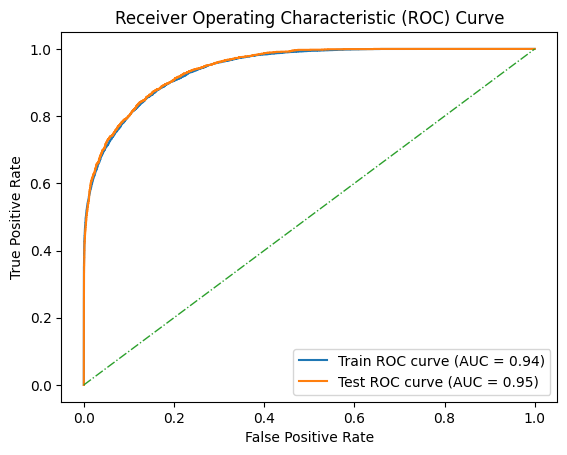

In [41]:
#quick look at the performance of our baseline model.  We'll take a peek
#at the ROC curve first, even though our metric of interest is recall, and F1.

#compute the predicted probabilities
y_prob_train = baseline_logreg.predict_proba(X_train)[:, 1]
y_prob_test = baseline_logreg.predict_proba(X_test)[:, 1]

#compute the false positive rate (fpr), true positive rate (tpr), and thresholds for train and test sets
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

#compute the area under the ROC curve (AUC) for train and test sets
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

#plot the ROC curve for train and test sets
plt.figure()
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], lw=1, linestyle='-.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

** Need insight here

###Tuned Logisitic Regression

*Hyperparameters helper*

`penalty:` 'l2' is the default, but you can also try other penalties like 'l1' or 'elasticnet' depending on the problem and the nature of your dataset. 'l2' regularization is commonly used as it can help reduce overfitting.

`fit_intercept:` The default is True, meaning the model will include an intercept term. You can try both True and False to see if including or excluding the intercept improves the model's performance.

`C:` This parameter controls the inverse of the regularization strength. Smaller values of C result in stronger regularization, while larger values reduce the strength of regularization. You can try different values to find the optimal level of regularization for your problem.

`solver:` The choice of solver depends on the type of problem and the size of the dataset. 'lbfgs' is a good choice for small datasets, while 'liblinear' is efficient for larger datasets. 'newton-cg' is also a good option. You can try different solvers to see which one performs the best.

`max_iter:` This parameter determines the maximum number of iterations for the solver to converge. The default is 100. If the solver does not converge, you may need to increase this value.

In [42]:
#parameters for our gridsearch, model optimization
parameters = {
    'estimator__penalty' : ['l2'], #default 'l2'
    'estimator__fit_intercept':[True, False], #default 'True'
    'estimator__C'       : [1, 5, 10, 20, 50], #default '1'
    'estimator__solver'  : ['newton-cg', 'lbfgs', 'liblinear'], #default 'lbfgs'
    'estimator__max_iter'  : [50, 100, 200] #default '100'
}

#create the grid, with "logreg_pipeline" as the estimator
best_logreg = GridSearchCV(estimator=baseline_logreg,
                          param_grid=parameters,
                          scoring='precision',
                          cv=3,
                          n_jobs=-1
)


In [43]:
#train the pipeline (tranformations & predictor)
best_logreg.fit(X_train, y_train);

#let's take a look at our best parameters
best_logreg.best_params_

{'estimator__C': 1,
 'estimator__fit_intercept': False,
 'estimator__max_iter': 50,
 'estimator__penalty': 'l2',
 'estimator__solver': 'newton-cg'}

In [44]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
best_logreg_roc_score_train = roc_auc_score(y_train, best_logreg.predict(X_train))
best_logreg_roc_score_test = roc_auc_score(y_test, best_logreg.predict(X_test))

#capture precision scores for test and train
#best_logreg_precision_score_train_cv = cross_val_score(estimator=best_logreg, X=X_train,  y=y_train,
#                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

best_logreg_precision_score_train = precision_score(y_train, best_logreg.predict(X_train))
best_logreg_precision_score_test = precision_score(y_test, best_logreg.predict(X_test))

#capture f1 scores for test and train
best_logreg_f1_score_train = f1_score(y_train, best_logreg.predict(X_train))
best_logreg_f1_score_test = f1_score(y_test, best_logreg.predict(X_test))

#capture recall scores for test and train
best_logreg_recall_score_train = recall_score(y_train, best_logreg.predict(X_train))
best_logreg_recall_score_test = recall_score(y_test, best_logreg.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {best_logreg_roc_score_train :.2%}")
print(f" Test ROC Score: {best_logreg_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {best_logreg_precision_score_train :.2%}")
print(f" Test Precision score: {best_logreg_precision_score_test :.2%}")
#print(f" Mean Cross Validated Precision Score: {best_logreg_precision_score_train_cv :.2%}")
print(divider)

print(f" Train F1 score: {best_logreg_recall_score_train :.2%}")
print(f" Test F1 score: {best_logreg_recall_score_test :.2%}")
print(divider)

print(f" Train Recall score: {best_logreg_f1_score_train :.2%}")
print(f" Test Recall  score: {best_logreg_f1_score_test :.2%}")
print(divider, '\n')


 Performance Comparison 

--------------------------------------------------
 Train ROC Score: 84.95%
 Test ROC Score: 85.02%
--------------------------------------------------
 Train Precision score: 43.02%
 Test Precision score: 44.22%
--------------------------------------------------
 Train F1 score: 79.58%
 Test F1 score: 79.69%
--------------------------------------------------
 Train Recall score: 55.85%
 Test Recall  score: 56.88%
-------------------------------------------------- 



In [48]:
#comparison of our first 2 models
models = ['Baseline Logreg', 'Best Logreg']
train_precision_scores = [baseline_logreg_precision_score_train,
                          best_logreg_precision_score_train]

test_precision_scores = [baseline_logreg_precision_score_test,
                         best_logreg_precision_score_test]

data = {'Model': models,
        'Train Precision Score': train_precision_scores,
        'Test Precision Score': test_precision_scores}

table = tabulate(data,
                 headers='keys',
                 tablefmt='presto')

print(table)


 Model           |   Train Precision Score |   Test Precision Score
-----------------+-------------------------+------------------------
 Baseline Logreg |                0.419432 |               0.432226
 Best Logreg     |                0.430175 |               0.442249


We saw a slight improvement in our tuned logistic regression model 44% vs 43%.  We are going to continue looking at additional models to see if we can improve upon this score.  I will display the comparison below for additional context.

##Decision Tree

###Baseline Decision Tree

In [49]:
# Baseline model
baseline_tree = ImPipeline(steps=[('sm', SMOTE(random_state=42)),
                                  ('scale', StandardScaler()),
                                  ('estimator', DecisionTreeClassifier(random_state=42))])

# Train model
baseline_tree.fit(X_train, y_train);

In [50]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
baseline_tree_roc_score_train = roc_auc_score(y_train, baseline_tree.predict(X_train))
baseline_tree_roc_score_test = roc_auc_score(y_test, baseline_tree.predict(X_test))

#capture precision scores for test and train
#baseline_tree_precision_score_train_cv = cross_val_score(estimator=baseline_tree, X=X_train,  y=y_train,
#                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

baseline_tree_precision_score_train = precision_score(y_train, baseline_tree.predict(X_train))
baseline_tree_precision_score_test = precision_score(y_test, baseline_tree.predict(X_test))

#capture f1 scores for test and train
baseline_tree_f1_score_train = f1_score(y_train, baseline_tree.predict(X_train))
baseline_tree_f1_score_test = f1_score(y_test, baseline_tree.predict(X_test))

#capture recall scores for test and train
baseline_tree_recall_score_train = recall_score(y_train, baseline_tree.predict(X_train))
baseline_tree_recall_score_test = recall_score(y_test, baseline_tree.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {baseline_tree_roc_score_train :.2%}")
print(f" Test ROC Score: {baseline_tree_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {baseline_tree_precision_score_train :.2%}")
print(f" Test Precision score: {baseline_tree_precision_score_test :.2%}")
#print(f" Mean Cross Validated Precision Score: {baseline_tree_precision_score_train_cv :.2%}")
print(divider)

print(f" Train Recall score: {baseline_tree_recall_score_train :.2%}")
print(f" Test Recall score: {baseline_tree_recall_score_test :.2%}")
print(divider)

print(f" Train F1 score: {baseline_tree_f1_score_train :.2%}")
print(f" Test F1 score: {baseline_tree_f1_score_test :.2%}")
print(divider, '\n')


 Performance Comparison 

--------------------------------------------------
 Train ROC Score: 99.60%
 Test ROC Score: 85.13%
--------------------------------------------------
 Train Precision score: 99.65%
 Test Precision score: 69.92%
--------------------------------------------------
 Train Recall score: 99.24%
 Test Recall score: 73.30%
--------------------------------------------------
 Train F1 score: 99.44%
 Test F1 score: 71.57%
-------------------------------------------------- 



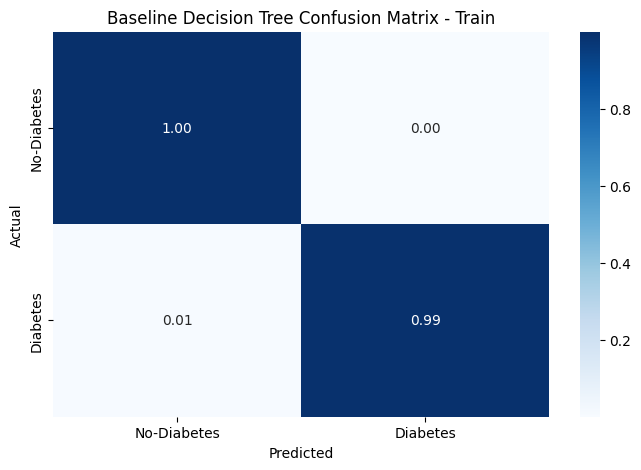

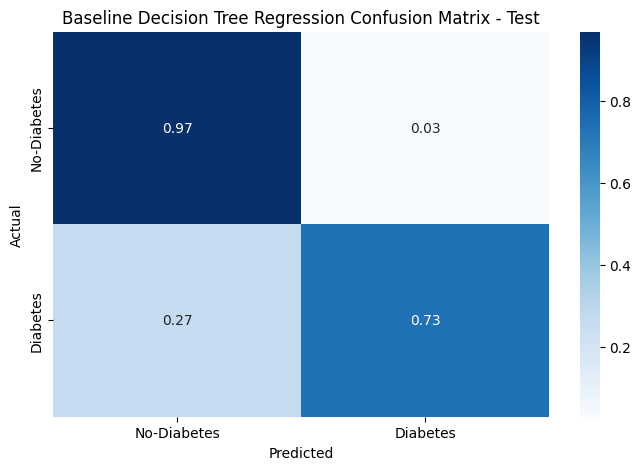

In [51]:
#define the labels for the confusion matrix
labels = ['No-Diabetes', 'Diabetes']

#compute the confusion matrix for the baseline decision tree - Train
train_pred = baseline_tree.predict(X_train)
train_cm = confusion_matrix(y_train, train_pred, normalize='true')

#plotting confusion matrix for the baseline decision tree - Train
plt.figure(figsize=(8, 5))
sns.heatmap(train_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline Decision Tree Confusion Matrix - Train")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

#compute the confusion matrix for the baseline decision tree - Test
test_pred = baseline_tree.predict(X_test)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

#plotting confusion matrix for the baseline decision tree - Test
plt.figure(figsize=(8, 5))
sns.heatmap(test_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline Decision Tree Regression Confusion Matrix - Test")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()


Clealy overfitting, better performance than our baseline and tuned logreg models.  We can establish the overfitting insight becaues of the delta between our train and test scores.  Our next steps will be to pick the best hyperparameters to penalize our model for picking the obvious choices within the training data.  Although we do see a better Precision score, we are beginning to sacrifice some performance on our F1 Score metric.

###Tuned Decision Tree

*Hyperparameter Helper*

`criterion:` It's common to try both 'gini' and 'entropy'. 'Gini' measures impurity based on the Gini index, while 'entropy' uses information gain. You can see which one performs better during the grid search.

`max_depth:` This parameter controls the maximum depth of the decision tree. Higher values allow for more complex trees but may lead to overfitting. You can try different values to see which provides the best balance between model complexity and performance.

`max_features:` This parameter determines the number of features to consider when looking for the best split at each node. 'None' means all features will be considered. You can try different values to see if limiting the number of features improves the model's generalization ability.

`min_samples_split` and `min_samples_leaf:` These parameters control the minimum number of samples required to split an internal node and the minimum number of samples required to be at a leaf node, respectively. Smaller values may result in more complex trees and can lead to overfitting. You can try different values to find the optimal balance.

In [52]:
#let's tune this model!
parameters = {
    'estimator__criterion': ['gini', 'entropy'], #default 'gini'
    'estimator__max_depth': [None, 3, 5], #default 'None'
    'estimator__max_features': [None, 15,  5], #default 'None'
    'estimator__min_samples_split': [2, 5, 7], #default '2'
    'estimator__min_samples_leaf': [1, 2, 5] #default '1'
            }

#grid with our baseline tree as our estimator
best_tree = GridSearchCV(estimator=baseline_tree,
                          param_grid=parameters,
                          scoring='precision',
                          cv=3,
                          n_jobs=-1
                        )



In [53]:
#train the pipeline based on our most appropriate parameters
best_tree.fit(X_train, y_train);
best_tree.best_params_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'estimator__criterion': 'gini',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2}

In [54]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
best_tree_roc_score_train = roc_auc_score(y_train, best_tree.predict(X_train))
best_tree_roc_score_test = roc_auc_score(y_test, best_tree.predict(X_test))

#capture precision scores for test and train
#best_tree_precision_score_train_cv = cross_val_score(estimator=best_tree, X=X_train,  y=y_train,
#                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

best_tree_precision_score_train = precision_score(y_train, best_tree.predict(X_train))
best_tree_precision_score_test = precision_score(y_test, best_tree.predict(X_test))

#capture f1 scores for test and train
best_tree_f1_score_train = f1_score(y_train, best_tree.predict(X_train))
best_tree_f1_score_test = f1_score(y_test, best_tree.predict(X_test))

#capture recall scores for test and train
best_tree_recall_score_train = recall_score(y_train, best_tree.predict(X_train))
best_tree_recall_score_test = recall_score(y_test, best_tree.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {best_tree_roc_score_train :.2%}")
print(f" Test ROC Score: {best_tree_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {best_tree_precision_score_train :.2%}")
print(f" Test Precision score: {best_tree_precision_score_test :.2%}")
#print(f" Mean Cross Validated Precision Score: {best_tree_precision_score_train_cv :.2%}")
print(divider)

print(f" Train Recall score: {best_tree_recall_score_train :.2%}")
print(f" Test Recall score: {best_tree_recall_score_test :.2%}")
print(divider)

print(f" Train F1 score: {best_tree_f1_score_train :.2%}")
print(f" Test F1 score: {best_tree_f1_score_test :.2%}")
print(divider, '\n')


 Performance Comparison 

--------------------------------------------------
 Train ROC Score: 83.40%
 Test ROC Score: 83.59%
--------------------------------------------------
 Train Precision score: 100.00%
 Test Precision score: 100.00%
--------------------------------------------------
 Train Recall score: 66.81%
 Test Recall score: 67.18%
--------------------------------------------------
 Train F1 score: 80.10%
 Test F1 score: 80.37%
-------------------------------------------------- 



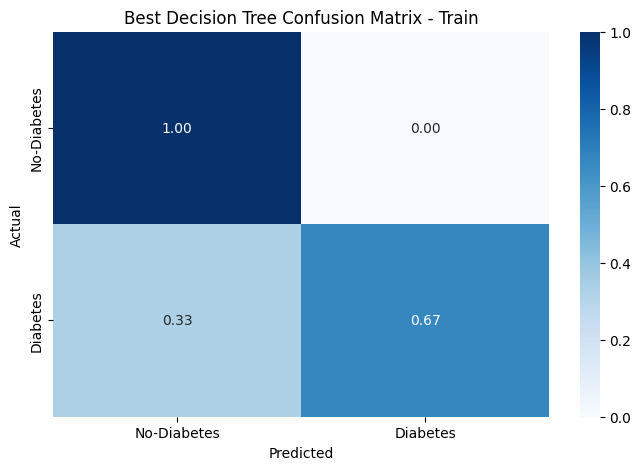

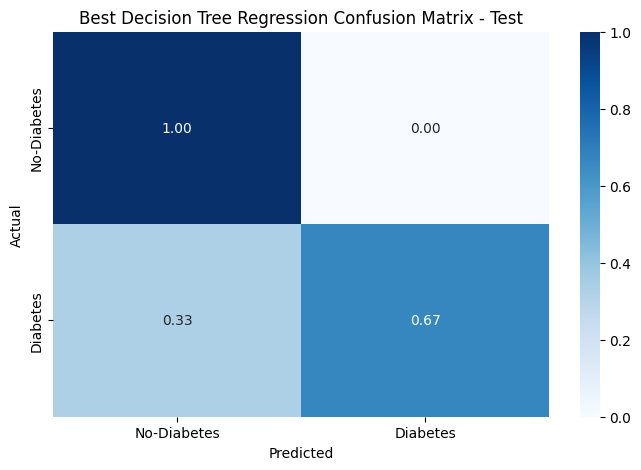

In [55]:
#define the labels for the confusion matrix
labels = ['No-Diabetes', 'Diabetes']

#compute the confusion matrix for the best decision tree - Train
train_pred = best_tree.predict(X_train)
train_cm = confusion_matrix(y_train, train_pred, normalize='true')

#plotting confusion matrix for the best decision tree - Train
plt.figure(figsize=(8, 5))
sns.heatmap(train_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Best Decision Tree Confusion Matrix - Train")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

#compute the confusion matrix for the best decision tree - Test
test_pred = best_tree.predict(X_test)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

#plotting confusion matrix for the best decision tree - Test
plt.figure(figsize=(8, 5))
sns.heatmap(test_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Best Decision Tree Regression Confusion Matrix - Test")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()


In [58]:
#run our comparison from all recent models to understand performance
models = ['Baseline Logreg',
          'Best Logreg',
          'Baseline Decision Tree',
          'Best Decision Tree']

train_precision_scores = [baseline_logreg_precision_score_train,
                          best_logreg_precision_score_train,
                          baseline_tree_precision_score_train,
                          best_tree_precision_score_train]

test_precision_scores = [baseline_logreg_precision_score_test,
                         best_logreg_precision_score_test,
                         baseline_tree_precision_score_test,
                         best_tree_precision_score_test]

train_f1_scores = [baseline_logreg_f1_score_train,
                          best_logreg_f1_score_train,
                          baseline_tree_f1_score_train,
                          best_tree_f1_score_train]

test_f1_scores = [baseline_logreg_f1_score_test,
                         best_logreg_f1_score_test,
                         baseline_tree_f1_score_test,
                         best_tree_f1_score_test]

data = {'Model': models,
        'Train Precision Score': train_precision_scores,
        'Test Precision Score': test_precision_scores,
        'Train F1 Score': train_f1_scores,
        'Test F1 Score': test_f1_scores}

table = tabulate(data,
                 headers='keys',
                 tablefmt='presto')

print(table)


 Model                  |   Train Precision Score |   Test Precision Score |   Train F1 Score |   Test F1 Score
------------------------+-------------------------+------------------------+------------------+-----------------
 Baseline Logreg        |                0.419432 |               0.432226 |         0.551109 |        0.561701
 Best Logreg            |                0.430175 |               0.442249 |         0.558478 |        0.568822
 Baseline Decision Tree |                0.996498 |               0.699173 |         0.994441 |        0.715686
 Best Decision Tree     |                1        |               1        |         0.801026 |        0.803713


We were able to increase our hypertuned decision tree model to perfect precision, predicting 100% of positive cases in both test and train sets.  However it is important to note that our F1 scores are lower, indicating a trade off between our recall and precision scoring metrics.  And we can actually see that because our recall scores before were higher than mid 60%s where they are currently.  We will continue to evaluate additional models to see if we can optimize further.

##Random Forest

###Baseline Random Forest

In [59]:
#moving along to our next model
baseline_RF = ImPipeline(steps=[('sm', SMOTE(random_state=42)),
                                ('scale', StandardScaler()),
                                ('estimator', RandomForestClassifier(random_state=42))])


#train model
baseline_RF.fit(X_train, y_train);

In [60]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
baseline_RF_roc_score_train = roc_auc_score(y_train, baseline_RF.predict(X_train))
baseline_RF_roc_score_test = roc_auc_score(y_test, baseline_RF.predict(X_test))

#capture precision scores for test and train
#baseline_RF_precision_score_train_cv = cross_val_score(estimator=baseline_RF, X=X_train,  y=y_train,
#                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

baseline_RF_precision_score_train = precision_score(y_train, baseline_RF.predict(X_train))
baseline_RF_precision_score_test = precision_score(y_test, baseline_RF.predict(X_test))

#capture f1 scores for test and train
baseline_RF_f1_score_train = f1_score(y_train, baseline_RF.predict(X_train))
baseline_RF_f1_score_test = f1_score(y_test, baseline_RF.predict(X_test))

#capture recall scores for test and train
baseline_RF_recall_score_train = recall_score(y_train, baseline_RF.predict(X_train))
baseline_RF_recall_score_test = recall_score(y_test, baseline_RF.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {baseline_RF_roc_score_train :.2%}")
print(f" Test ROC Score: {baseline_RF_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {baseline_RF_precision_score_train :.2%}")
print(f" Test Precision score: {baseline_RF_precision_score_test :.2%}")
#print(f" Mean Cross Validated Precision Score: {baseline_RF_precision_score_train_cv :.2%}")
print(divider)

print(f" Train Recall score: {baseline_RF_recall_score_train :.2%}")
print(f" Test Recall score: {baseline_RF_recall_score_test :.2%}")
print(divider)

print(f" Train F1 score: {baseline_RF_f1_score_train :.2%}")
print(f" Test F1 score: {baseline_RF_f1_score_test :.2%}")
print(divider, '\n')


 Performance Comparison 

--------------------------------------------------
 Train ROC Score: 99.70%
 Test ROC Score: 85.30%
--------------------------------------------------
 Train Precision score: 99.41%
 Test Precision score: 75.33%
--------------------------------------------------
 Train Recall score: 99.46%
 Test Recall score: 72.89%
--------------------------------------------------
 Train F1 score: 99.44%
 Test F1 score: 74.09%
-------------------------------------------------- 



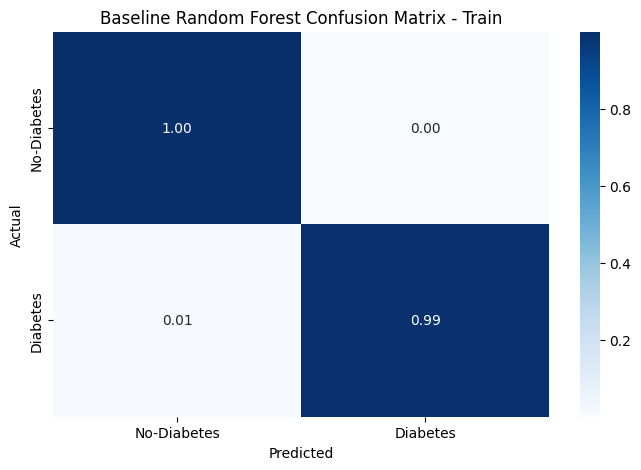

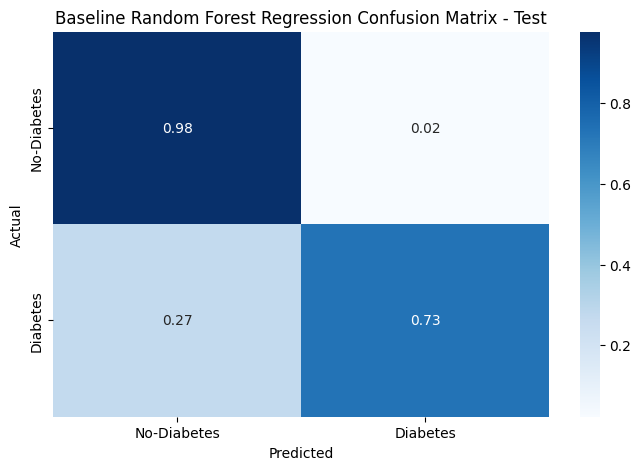

In [61]:
#define the labels for the confusion matrix
labels = ['No-Diabetes', 'Diabetes']

#compute the confusion matrix for the baseline Random Forest - Train
train_pred = baseline_RF.predict(X_train)
train_cm = confusion_matrix(y_train, train_pred, normalize='true')

#plotting confusion matrix for the baseline Random Forest - Train
plt.figure(figsize=(8, 5))
sns.heatmap(train_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline Random Forest Confusion Matrix - Train")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

#compute the confusion matrix for the baseline Random Forest - Test
test_pred = baseline_RF.predict(X_test)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

#plotting confusion matrix for the baseline Random Forest - Test
plt.figure(figsize=(8, 5))
sns.heatmap(test_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline Random Forest Regression Confusion Matrix - Test")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()


Again we are seeing some overfitting within our baseline model, which I think is to be expected (at least between the Decision Tree model and the Random Forest).  We will continue to move on with our hypertuning, and see if we can zero in a bit better on our metrics of interest, and then we will compare against the previous models.

###Tuned Random Forest

*Hyperparameter Helper*

`n_estimators:` This parameter determines the number of decision trees in the random forest. Increasing the number of estimators can improve the model's performance, but it also increases the computational cost. You can try different values to find the optimal number of estimators for your problem.

`criterion:` Random Forest supports two criteria for splitting: 'gini' (default) and 'entropy'. Both criteria measure the quality of a split, and the choice depends on your specific problem and dataset.

`max_depth:` This parameter controls the maximum depth of each decision tree in the random forest. Setting a smaller value can prevent overfitting, while larger values can increase model complexity. You can try different values to find the optimal maximum depth.

`max_features:` This parameter determines the maximum number of features to consider when looking for the best split. 'auto' (default) considers all features, while 'sqrt' and 'log2' consider the square root and logarithm of the total number of features, respectively. You can also try specific values to limit the number of features considered.

`min_samples_split and min_samples_leaf:` These parameters control the minimum number of samples required to split an internal node and the minimum number of samples required to be a leaf node, respectively. Higher values can prevent overfitting, but too high values may result in underfitting. You can experiment with different values to find the right balance.

In [62]:
#parameters for our gridsearch, model optimization
parameters = {
    'estimator__n_estimators': [50, 100, 150], #default 100
    'estimator__criterion': ['entropy', 'gini'], #default 'gini'
    'estimator__max_depth': [None, 2, 5], #default None
    'estimator__max_features': [2, 5], #default 'auto'
    'estimator__min_samples_split': [2, 5, 10], #default 2
    'estimator__min_samples_leaf': [1, 2, 4] #default 1
            }

best_RF = GridSearchCV(estimator=baseline_RF,
                        param_grid=parameters,
                        scoring='precision',
                        cv=3,
                        n_jobs=-1
                      )


In [63]:
#train the pipeline based on our most appropriate parameters
best_RF.fit(X_train, y_train)
best_RF.best_params_

{'estimator__criterion': 'entropy',
 'estimator__max_depth': 2,
 'estimator__max_features': 5,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__n_estimators': 50}

In [64]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
best_RF_roc_score_train = roc_auc_score(y_train, best_RF.predict(X_train))
best_RF_roc_score_test = roc_auc_score(y_test, best_RF.predict(X_test))

#capture precision scores for test and train
#best_RF_precision_score_train_cv = cross_val_score(estimator=best_RF, X=X_train,  y=y_train,
#                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

best_RF_precision_score_train = precision_score(y_train, best_RF.predict(X_train))
best_RF_precision_score_test = precision_score(y_test, best_RF.predict(X_test))

#capture f1 scores for test and train
best_RF_f1_score_train = f1_score(y_train, best_RF.predict(X_train))
best_RF_f1_score_test = f1_score(y_test, best_RF.predict(X_test))

#capture recall scores for test and train
best_RF_recall_score_train = recall_score(y_train, best_RF.predict(X_train))
best_RF_recall_score_test = recall_score(y_test, best_RF.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {best_RF_roc_score_train :.2%}")
print(f" Test ROC Score: {best_RF_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {best_RF_precision_score_train :.2%}")
print(f" Test Precision score: {best_RF_precision_score_test :.2%}")
#print(f" Mean Cross Validated Precision Score: {best_RF_precision_score_train_cv :.2%}")
print(divider)

print(f" Train Recall score: {best_RF_recall_score_train :.2%}")
print(f" Test Recall score: {best_RF_recall_score_test :.2%}")
print(divider)

print(f" Train F1 score: {best_RF_f1_score_train :.2%}")
print(f" Test F1 score: {best_RF_f1_score_test :.2%}")
print(divider, '\n')


 Performance Comparison 

--------------------------------------------------
 Train ROC Score: 83.40%
 Test ROC Score: 83.59%
--------------------------------------------------
 Train Precision score: 100.00%
 Test Precision score: 100.00%
--------------------------------------------------
 Train Recall score: 66.81%
 Test Recall score: 67.18%
--------------------------------------------------
 Train F1 score: 80.10%
 Test F1 score: 80.37%
-------------------------------------------------- 



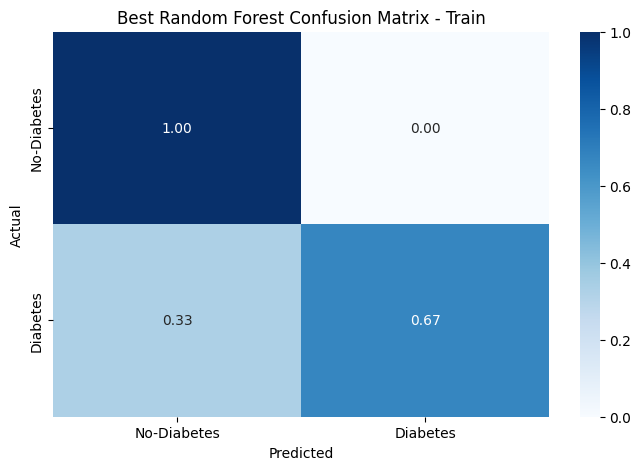

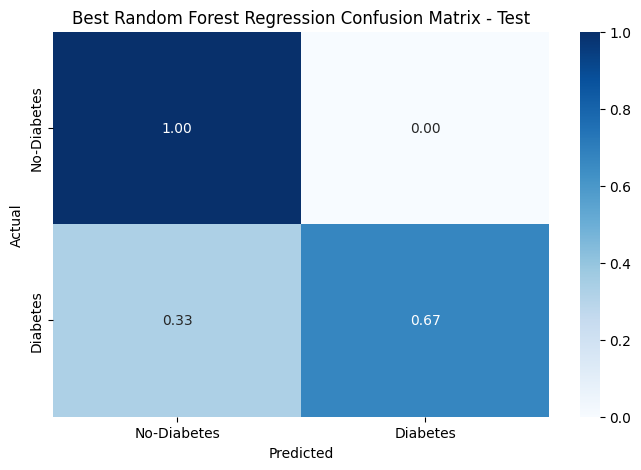

In [65]:
#define the labels for the confusion matrix
labels = ['No-Diabetes', 'Diabetes']

#compute the confusion matrix for the best Random Forest - Train
train_pred = best_RF.predict(X_train)
train_cm = confusion_matrix(y_train, train_pred, normalize='true')

#plotting confusion matrix for the best Random Forest - Train
plt.figure(figsize=(8, 5))
sns.heatmap(train_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Best Random Forest Confusion Matrix - Train")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

#compute the confusion matrix for the best Random Forest - Test
test_pred = best_RF.predict(X_test)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

#plotting confusion matrix for the best Random Forest - Test
plt.figure(figsize=(8, 5))
sns.heatmap(test_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Best Random Forest Regression Confusion Matrix - Test")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()


Overall, the model appears to have high precision and F1 scores, indicating accurate positive predictions. However, the recall score is relatively lower, suggesting that the model may have difficulty correctly identifying all positive cases.

In [66]:
#run our comparison from all recent models to understand performance
models = ['Baseline Logreg',
          'Best Logreg',
          'Baseline Decision Tree',
          'Best Decision Tree',
          'Baseline Random Forest',
          'Best Random Forest']

train_precision_scores = [baseline_logreg_precision_score_train,
                          best_logreg_precision_score_train,
                          baseline_tree_precision_score_train,
                          best_tree_precision_score_train,
                          baseline_RF_precision_score_train,
                          best_RF_precision_score_train]

test_precision_scores = [baseline_logreg_precision_score_test,
                         best_logreg_precision_score_test,
                         baseline_tree_precision_score_test,
                         best_tree_precision_score_test,
                         baseline_RF_precision_score_test,
                         best_RF_precision_score_test]

train_f1_scores = [baseline_logreg_f1_score_train,
                   best_logreg_f1_score_train,
                   baseline_tree_f1_score_train,
                   best_tree_f1_score_train,
                   baseline_RF_f1_score_train,
                   best_RF_f1_score_train]

test_f1_scores = [baseline_logreg_f1_score_test,
                  best_logreg_f1_score_test,
                  baseline_tree_f1_score_test,
                  best_tree_f1_score_test,
                  baseline_RF_f1_score_test,
                  best_RF_f1_score_test]

data = {'Model': models,
        'Train Precision Score': train_precision_scores,
        'Test Precision Score': test_precision_scores,
        'Train F1 Score': train_f1_scores,
        'Test F1 Score': test_f1_scores}

table = tabulate(data,
                 headers='keys',
                 tablefmt='presto')

print(table)


 Model                  |   Train Precision Score |   Test Precision Score |   Train F1 Score |   Test F1 Score
------------------------+-------------------------+------------------------+------------------+-----------------
 Baseline Logreg        |                0.419432 |               0.432226 |         0.551109 |        0.561701
 Best Logreg            |                0.430175 |               0.442249 |         0.558478 |        0.568822
 Baseline Decision Tree |                0.996498 |               0.699173 |         0.994441 |        0.715686
 Best Decision Tree     |                1        |               1        |         0.801026 |        0.803713
 Baseline Random Forest |                0.994138 |               0.753302 |         0.994374 |        0.740895
 Best Random Forest     |                1        |               1        |         0.803713 |        0.803713


So far it appears that the "Best Random Forest" model would be the best performing among the models thus far. It achieves a perfect precision score (1.0) on both the training and test datasets, indicating that all positive predictions are correct. Additionally, it has relatively high F1 scores of 0.803713 for both training and testing, which suggests a good balance between precision and recall.

##XGBoost

###Baseline XGBoost

In [67]:
#moving along to our next model
baseline_xgb = ImPipeline(steps=[('sm', SMOTE(random_state=42)),
                                 ('scale', StandardScaler()),
                                 ('estimator', xgb.XGBClassifier(objective="binary:logistic", random_state=42))])

#train model
baseline_xgb.fit(X_train, y_train);

In [68]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
baseline_xgb_roc_score_train = roc_auc_score(y_train, baseline_xgb.predict(X_train))
baseline_xgb_roc_score_test = roc_auc_score(y_test, baseline_xgb.predict(X_test))

#capture precision scores for test and train
#baseline_xgb_precision_score_train_cv = cross_val_score(estimator=baseline_xgb, X=X_train,  y=y_train,
#                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

baseline_xgb_precision_score_train = precision_score(y_train, baseline_xgb.predict(X_train))
baseline_xgb_precision_score_test = precision_score(y_test, baseline_xgb.predict(X_test))

#capture f1 scores for test and train
baseline_xgb_f1_score_train = f1_score(y_train, baseline_xgb.predict(X_train))
baseline_xgb_f1_score_test = f1_score(y_test, baseline_xgb.predict(X_test))

#capture recall scores for test and train
baseline_xgb_recall_score_train = recall_score(y_train, baseline_xgb.predict(X_train))
baseline_xgb_recall_score_test = recall_score(y_test, baseline_xgb.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {baseline_xgb_roc_score_train :.2%}")
print(f" Test ROC Score: {baseline_xgb_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {baseline_xgb_precision_score_train :.2%}")
print(f" Test Precision score: {baseline_xgb_precision_score_test :.2%}")
#print(f" Mean Cross Validated Precision Score: {baseline_xgb_precision_score_train_cv :.2%}")
print(divider)

print(f" Train Recall score: {baseline_xgb_recall_score_train :.2%}")
print(f" Test Recall score: {baseline_xgb_recall_score_test :.2%}")
print(divider)

print(f" Train F1 score: {baseline_xgb_f1_score_train :.2%}")
print(f" Test F1 score: {baseline_xgb_f1_score_test :.2%}")
print(divider, '\n')


 Performance Comparison 

--------------------------------------------------
 Train ROC Score: 87.68%
 Test ROC Score: 84.88%
--------------------------------------------------
 Train Precision score: 93.22%
 Test Precision score: 88.31%
--------------------------------------------------
 Train Recall score: 75.88%
 Test Recall score: 70.65%
--------------------------------------------------
 Train F1 score: 83.66%
 Test F1 score: 78.50%
-------------------------------------------------- 



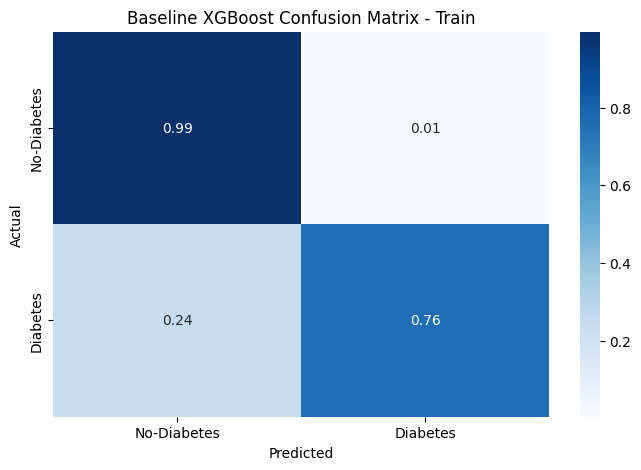

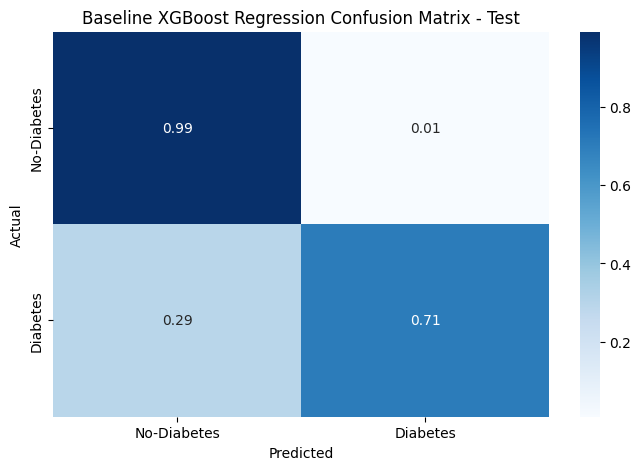

In [69]:
#define the labels for the confusion matrix
labels = ['No-Diabetes', 'Diabetes']

#compute the confusion matrix for the baseline xgboost - Train
train_pred = baseline_xgb.predict(X_train)
train_cm = confusion_matrix(y_train, train_pred, normalize='true')

#plotting confusion matrix for the baseline xgboost - Train
plt.figure(figsize=(8, 5))
sns.heatmap(train_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline XGBoost Confusion Matrix - Train")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

#compute the confusion matrix for the baseline xgboost - Test
test_pred = baseline_xgb.predict(X_test)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

#plotting confusion matrix for the baseline xgboost - Test
plt.figure(figsize=(8, 5))
sns.heatmap(test_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline XGBoost Regression Confusion Matrix - Test")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()


Some overfitting again as noticed by the difference between our train and test scores, however not as much as what we experienced in our decision tree and random forest models.  Even though we have lowered our perfect precision numbers, it looks like our recall and f1 score are performing generally well.  Let's move on to our tuned model to see how much additional we can improve.

In [78]:
#run our comparison from all recent models to understand performance
models = ['Baseline Logreg',
          'Best Logreg',
          'Baseline Decision Tree',
          'Best Decision Tree',
          'Baseline Random Forest',
          'Best Random Forest',
          'Baseline XGBoost']

train_precision_scores = [baseline_logreg_precision_score_train,
                          best_logreg_precision_score_train,
                          baseline_tree_precision_score_train,
                          best_tree_precision_score_train,
                          baseline_RF_precision_score_train,
                          best_RF_precision_score_train,
                          baseline_xgb_precision_score_train]

test_precision_scores = [baseline_logreg_precision_score_test,
                         best_logreg_precision_score_test,
                         baseline_tree_precision_score_test,
                         best_tree_precision_score_test,
                         baseline_RF_precision_score_test,
                         best_RF_precision_score_test,
                         baseline_xgb_precision_score_test]

train_f1_scores = [baseline_logreg_f1_score_train,
                   best_logreg_f1_score_train,
                   baseline_tree_f1_score_train,
                   best_tree_f1_score_train,
                   baseline_RF_f1_score_train,
                   best_RF_f1_score_train,
                   baseline_xgb_f1_score_train]

test_f1_scores = [baseline_logreg_f1_score_test,
                  best_logreg_f1_score_test,
                  baseline_tree_f1_score_test,
                  best_tree_f1_score_test,
                  baseline_RF_f1_score_test,
                  best_RF_f1_score_test,
                  baseline_xgb_f1_score_test]

data = {'Model': models,
        'Train Precision Score': train_precision_scores,
        'Test Precision Score': test_precision_scores,
        'Train F1 Score': train_f1_scores,
        'Test F1 Score': test_f1_scores}

table = tabulate(data,
                 headers='keys',
                 tablefmt='presto')

print(table)


 Model                  |   Train Precision Score |   Test Precision Score |   Train F1 Score |   Test F1 Score
------------------------+-------------------------+------------------------+------------------+-----------------
 Baseline Logreg        |                0.419432 |               0.432226 |         0.551109 |        0.561701
 Best Logreg            |                0.430175 |               0.442249 |         0.558478 |        0.568822
 Baseline Decision Tree |                0.996498 |               0.699173 |         0.994441 |        0.715686
 Best Decision Tree     |                1        |               1        |         0.801026 |        0.803713
 Baseline Random Forest |                0.994138 |               0.753302 |         0.994374 |        0.740895
 Best Random Forest     |                1        |               1        |         0.801026 |        0.803713
 Baseline XGBoost       |                0.93223  |               0.883058 |         0.836596 |        

###Tuned XGBoost

*Hyperparameter Helper*

`n_estimators:` This parameter specifies the number of boosting rounds (decision trees) to be built. The default value is 100.

`learning_rate:` Also known as the "eta" parameter, it controls the step size shrinkage during each boosting iteration. A lower learning rate requires more boosting rounds but can lead to better generalization. The default value is 0.1.

`max_depth:` This parameter sets the maximum depth of each decision tree in the boosting process. Higher values can make the model more complex and prone to overfitting. The default value is 3.

`gamma:` This parameter specifies the minimum loss reduction required to make a further partition on a leaf node during the tree-building process. Higher values lead to more conservative tree growth. The default value is 0.

`min_child_weight:` This parameter sets the minimum sum of instance weights (hessian) required in a child node. Higher values lead to more conservative tree growth. The default value is 1.

`subsample:` This parameter specifies the fraction of samples to be used for training each individual tree. Lower values make the model more conservative by using less data. The default value is 1 (use all samples).

`colsample_bytree:` This parameter specifies the fraction of features to be used for training each individual tree. Lower values make the model more conservative by using fewer features. The default value is 1 (use all features).

In [72]:
#tuning our XGB model
parameters = {
    "estimator__n_estimators": [50, 100], #default 100
    "estimator__learning_rate": [0.05, 0.1], #default 0.1
    "estimator__max_depth": [3, 4], #default 3
    'estimator__gamma': [0, 0.5], #default 0
    'estimator__min_child_weight': [1, 3], #default 1
    'estimator__subsample': [0.5, 1], #default 1
    'estimator__colsample_bytree':[0.5, 1] #default 1
            }

best_xgb = GridSearchCV(estimator=baseline_xgb,
                        param_grid=parameters,
                        scoring='precision',
                        cv=3,
                        n_jobs=-1
                       )



In [73]:
#train the pipeline based on our most appropriate parameters
best_xgb.fit(X_train, y_train)
best_xgb.best_params_

{'estimator__colsample_bytree': 1,
 'estimator__gamma': 0,
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': 4,
 'estimator__min_child_weight': 3,
 'estimator__n_estimators': 100,
 'estimator__subsample': 1}

In [74]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
best_xgb_roc_score_train = roc_auc_score(y_train, best_xgb.predict(X_train))
best_xgb_roc_score_test = roc_auc_score(y_test, best_xgb.predict(X_test))

#capture precision scores for test and train
#best_xgb_precision_score_train_cv = cross_val_score(estimator=best_xgb, X=X_train,  y=y_train,
#                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

best_xgb_precision_score_train = precision_score(y_train, best_xgb.predict(X_train))
best_xgb_precision_score_test = precision_score(y_test, best_xgb.predict(X_test))

#capture f1 scores for test and train
best_xgb_f1_score_train = f1_score(y_train, best_xgb.predict(X_train))
best_xgb_f1_score_test = f1_score(y_test, best_xgb.predict(X_test))

#capture recall scores for test and train
best_xgb_recall_score_train = recall_score(y_train, best_xgb.predict(X_train))
best_xgb_recall_score_test = recall_score(y_test, best_xgb.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {best_xgb_roc_score_train :.2%}")
print(f" Test ROC Score: {best_xgb_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {best_xgb_precision_score_train :.2%}")
print(f" Test Precision score: {best_xgb_precision_score_test :.2%}")
#print(f" Mean Cross Validated Precision Score: {best_xgb_precision_score_train_cv :.2%}")
print(divider)

print(f" Train Recall score: {best_xgb_recall_score_train :.2%}")
print(f" Test Recall score: {best_xgb_recall_score_test :.2%}")
print(divider)

print(f" Train F1 score: {best_xgb_f1_score_train :.2%}")
print(f" Test F1 score: {best_xgb_f1_score_test :.2%}")
print(divider, '\n')


 Performance Comparison 

--------------------------------------------------
 Train ROC Score: 84.85%
 Test ROC Score: 84.79%
--------------------------------------------------
 Train Precision score: 88.49%
 Test Precision score: 89.55%
--------------------------------------------------
 Train Recall score: 70.53%
 Test Recall score: 70.38%
--------------------------------------------------
 Train F1 score: 78.50%
 Test F1 score: 78.81%
-------------------------------------------------- 



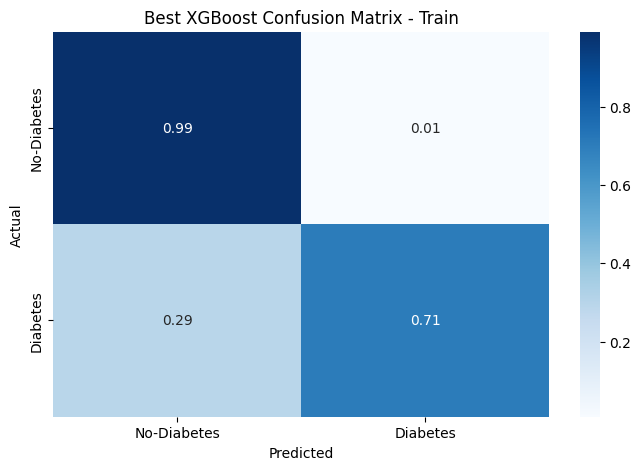

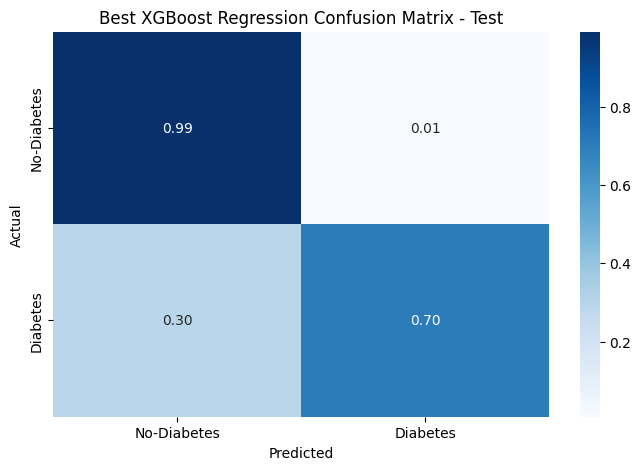

In [75]:
#define the labels for the confusion matrix
labels = ['No-Diabetes', 'Diabetes']

#compute the confusion matrix for the best xgboost - Train
train_pred = best_xgb.predict(X_train)
train_cm = confusion_matrix(y_train, train_pred, normalize='true')

#plotting confusion matrix for the best xgboost - Train
plt.figure(figsize=(8, 5))
sns.heatmap(train_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Best XGBoost Confusion Matrix - Train")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

#compute the confusion matrix for the best xgboost - Test
test_pred = best_xgb.predict(X_test)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

#plotting confusion matrix for the best xgboost - Test
plt.figure(figsize=(8, 5))
sns.heatmap(test_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Best XGBoost Regression Confusion Matrix - Test")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()


In [77]:
#run our comparison from all recent models to understand performance
models = ['Baseline Logreg',
          'Best Logreg',
          'Baseline Decision Tree',
          'Best Decision Tree',
          'Baseline Random Forest',
          'Best Random Forest',
          'Baseline XGBoost',
          'Best XGBoost']

train_precision_scores = [baseline_logreg_precision_score_train,
                          best_logreg_precision_score_train,
                          baseline_tree_precision_score_train,
                          best_tree_precision_score_train,
                          baseline_RF_precision_score_train,
                          best_RF_precision_score_train,
                          baseline_xgb_precision_score_train,
                          best_xgb_precision_score_train]

test_precision_scores = [baseline_logreg_precision_score_test,
                         best_logreg_precision_score_test,
                         baseline_tree_precision_score_test,
                         best_tree_precision_score_test,
                         baseline_RF_precision_score_test,
                         best_RF_precision_score_test,
                         baseline_xgb_precision_score_test,
                         best_xgb_precision_score_test]

train_f1_scores = [baseline_logreg_f1_score_train,
                   best_logreg_f1_score_train,
                   baseline_tree_f1_score_train,
                   best_tree_f1_score_train,
                   baseline_RF_f1_score_train,
                   best_RF_f1_score_train,
                   baseline_xgb_f1_score_train,
                   best_xgb_f1_score_train
                   ]

test_f1_scores = [baseline_logreg_f1_score_test,
                  best_logreg_f1_score_test,
                  baseline_tree_f1_score_test,
                  best_tree_f1_score_test,
                  baseline_RF_f1_score_test,
                  best_RF_f1_score_test,
                  baseline_xgb_f1_score_test,
                  best_xgb_f1_score_test]

data = {'Model': models,
        'Train Precision Score': train_precision_scores,
        'Test Precision Score': test_precision_scores,
        'Train F1 Score': train_f1_scores,
        'Test F1 Score': test_f1_scores}

table = tabulate(data,
                 headers='keys',
                 tablefmt='presto')

print(table)


 Model                  |   Train Precision Score |   Test Precision Score |   Train F1 Score |   Test F1 Score
------------------------+-------------------------+------------------------+------------------+-----------------
 Baseline Logreg        |                0.419432 |               0.432226 |         0.551109 |        0.561701
 Best Logreg            |                0.430175 |               0.442249 |         0.558478 |        0.568822
 Baseline Decision Tree |                0.996498 |               0.699173 |         0.994441 |        0.715686
 Best Decision Tree     |                1        |               1        |         0.801026 |        0.803713
 Baseline Random Forest |                0.994138 |               0.753302 |         0.994374 |        0.740895
 Best Random Forest     |                1        |               1        |         0.801026 |        0.803713
 Baseline XGBoost       |                0.93223  |               0.883058 |         0.836596 |        

Our tuned xgboost model, although didn't peform much better on the F1 score, did perform better on the precision score between the baseline XGB and the tuned XGB models.  Overall, still our best performing model is our Tuned or Best Random Forest model, predicting 100% of the positive cases, and scoring a .803713 on the f1 score.  This means we didn't sacrifice much by the way of false positives in order to get our high precision score.

##Neural Network

###Baseline Nueral Network

In [79]:
#moving along to our next model -- nitialize the MLP classifier
baseline_mlp = ImPipeline(steps=[('sm', SMOTE(random_state=42)),
                                 ('scale', StandardScaler()),
                                 ('estimator', MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', random_state=42))])

#train model
baseline_mlp.fit(X_train, y_train);

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [80]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
baseline_mlp_roc_score_train = roc_auc_score(y_train, baseline_mlp.predict(X_train))
baseline_mlp_roc_score_test = roc_auc_score(y_test, baseline_mlp.predict(X_test))

#capture precision scores for test and train
#baseline_mlp_precision_score_train_cv = cross_val_score(estimator=baseline_mlp, X=X_train,  y=y_train,
#                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

baseline_mlp_precision_score_train = precision_score(y_train, baseline_mlp.predict(X_train))
baseline_mlp_precision_score_test = precision_score(y_test, baseline_mlp.predict(X_test))

#capture f1 scores for test and train
baseline_mlp_f1_score_train = f1_score(y_train, baseline_mlp.predict(X_train))
baseline_mlp_f1_score_test = f1_score(y_test, baseline_mlp.predict(X_test))

#capture recall scores for test and train
baseline_mlp_recall_score_train = recall_score(y_train, baseline_mlp.predict(X_train))
baseline_mlp_recall_score_test = recall_score(y_test, baseline_mlp.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {baseline_mlp_roc_score_train :.2%}")
print(f" Test ROC Score: {baseline_mlp_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {baseline_mlp_precision_score_train :.2%}")
print(f" Test Precision score: {baseline_mlp_precision_score_test :.2%}")
#print(f" Mean Cross Validated Precision Score: {baseline_mlp_precision_score_train_cv :.2%}")
print(divider)

print(f" Train Recall score: {baseline_mlp_recall_score_train :.2%}")
print(f" Test Recall score: {baseline_mlp_recall_score_test :.2%}")
print(divider)

print(f" Train F1 score: {baseline_mlp_f1_score_train :.2%}")
print(f" Test F1 score: {baseline_mlp_f1_score_test :.2%}")
print(divider, '\n')


 Performance Comparison 

--------------------------------------------------
 Train ROC Score: 89.20%
 Test ROC Score: 86.70%
--------------------------------------------------
 Train Precision score: 54.68%
 Test Precision score: 51.67%
--------------------------------------------------
 Train Recall score: 84.86%
 Test Recall score: 80.65%
--------------------------------------------------
 Train F1 score: 66.51%
 Test F1 score: 62.98%
-------------------------------------------------- 



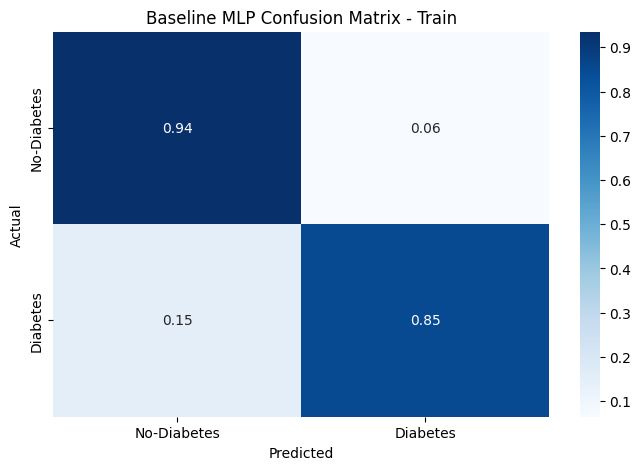

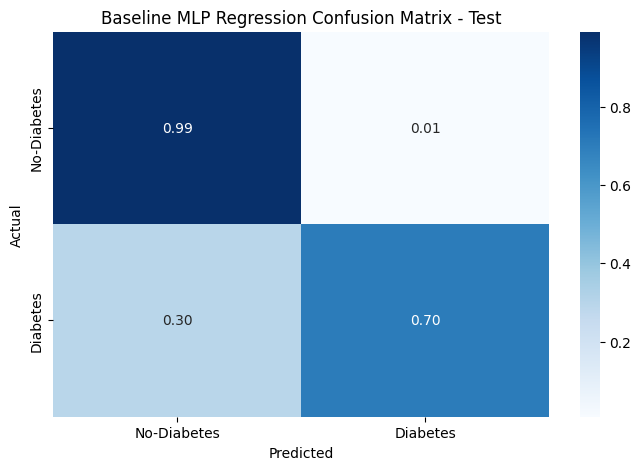

In [81]:
#define the labels for the confusion matrix
labels = ['No-Diabetes', 'Diabetes']

#compute the confusion matrix for the baseline_mlp - Train
train_pred = baseline_mlp.predict(X_train)
train_cm = confusion_matrix(y_train, train_pred, normalize='true')

#plotting confusion matrix for the baseline_mlp - Train
plt.figure(figsize=(8, 5))
sns.heatmap(train_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline MLP Confusion Matrix - Train")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

#compute the confusion matrix for the baseline_mlp - Test
test_pred = best_xgb.predict(X_test)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

#plotting confusion matrix for the baseline_mlp - Test
plt.figure(figsize=(8, 5))
sns.heatmap(test_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline MLP Regression Confusion Matrix - Test")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()


In [82]:
#run our comparison from all recent models to understand performance
models = ['Baseline Logreg',
          'Best Logreg',
          'Baseline Decision Tree',
          'Best Decision Tree',
          'Baseline Random Forest',
          'Best Random Forest',
          'Baseline XGBoost',
          'Best XGBoost',
          'Baseline MLP Neural Network']

train_precision_scores = [baseline_logreg_precision_score_train,
                          best_logreg_precision_score_train,
                          baseline_tree_precision_score_train,
                          best_tree_precision_score_train,
                          baseline_RF_precision_score_train,
                          best_RF_precision_score_train,
                          baseline_xgb_precision_score_train,
                          best_xgb_precision_score_train,
                          baseline_mlp_precision_score_train]

test_precision_scores = [baseline_logreg_precision_score_test,
                         best_logreg_precision_score_test,
                         baseline_tree_precision_score_test,
                         best_tree_precision_score_test,
                         baseline_RF_precision_score_test,
                         best_RF_precision_score_test,
                         baseline_xgb_precision_score_test,
                         best_xgb_precision_score_test,
                         baseline_mlp_precision_score_test]

train_f1_scores = [baseline_logreg_f1_score_train,
                   best_logreg_f1_score_train,
                   baseline_tree_f1_score_train,
                   best_tree_f1_score_train,
                   baseline_RF_f1_score_train,
                   best_RF_f1_score_train,
                   baseline_xgb_f1_score_train,
                   best_xgb_f1_score_train,
                   baseline_mlp_f1_score_train]

test_f1_scores = [baseline_logreg_f1_score_test,
                  best_logreg_f1_score_test,
                  baseline_tree_f1_score_test,
                  best_tree_f1_score_test,
                  baseline_RF_f1_score_test,
                  best_RF_f1_score_test,
                  baseline_xgb_f1_score_test,
                  best_xgb_f1_score_test,
                  baseline_mlp_f1_score_test]

data = {'Model': models,
        'Train Precision Score': train_precision_scores,
        'Test Precision Score': test_precision_scores,
        'Train F1 Score': train_f1_scores,
        'Test F1 Score': test_f1_scores}

table = tabulate(data,
                 headers='keys',
                 tablefmt='presto')

print(table)


 Model                       |   Train Precision Score |   Test Precision Score |   Train F1 Score |   Test F1 Score
-----------------------------+-------------------------+------------------------+------------------+-----------------
 Baseline Logreg             |                0.419432 |               0.432226 |         0.551109 |        0.561701
 Best Logreg                 |                0.430175 |               0.442249 |         0.558478 |        0.568822
 Baseline Decision Tree      |                0.996498 |               0.699173 |         0.994441 |        0.715686
 Best Decision Tree          |                1        |               1        |         0.801026 |        0.803713
 Baseline Random Forest      |                0.994138 |               0.753302 |         0.994374 |        0.740895
 Best Random Forest          |                1        |               1        |         0.801026 |        0.803713
 Baseline XGBoost            |                0.93223  |       

This performance isn't surprising based on the error message above.  Needless to say, this model needs tuned to really evaluate the performance of this classifier.

###Tuned Neural Network

*Hyperparameter Helper*

`hidden_layer_sizes:` This parameter defines the architecture of the neural network by specifying the number of neurons in each hidden layer. The values you provided indicate different configurations, such as a single hidden layer with 50 neurons, a single hidden layer with 100 neurons, two hidden layers each with 50 neurons, and two hidden layers each with 100 neurons.

`activation:` This parameter determines the activation function used in the neural network. The values 'relu' and 'tanh' correspond to the rectified linear unit and hyperbolic tangent activation functions, respectively. Different activation functions can have different effects on the learning process and performance of the neural network.

`learning_rate_init:` This parameter sets the initial learning rate for the neural network. The learning rate controls the step size during gradient descent, affecting how quickly the network learns. The values you provided are different options for the initial learning rate.

`alpha:` This parameter represents the L2 regularization term in the neural network's cost function. It helps prevent overfitting by adding a penalty term to the loss function. The values you provided are different options for the regularization strength.

In [103]:
mlpparameters = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)], #defaul '(100,)'
    #'activation': ['relu', 'tanh'], #default 'relu'
    'learning_rate_init': [0.001, 0.01, 0.1], #default '0.001'
    'alpha': [0.0001, 0.001, 0.01] #default '0.0001'
                }

best_mlp = GridSearchCV(estimator=baseline_mlp,
                        param_grid=mlpparameters,
                        scoring='precision',
                        cv=3,
                        n_jobs=-1
                       )


In [104]:
#train the pipeline based on our most appropriate parameters
best_mlp.fit(X_train,
             y_train)

best_mlp.best_params_

ValueError: ignored

In [ ]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
best_mlp_roc_score_train = roc_auc_score(y_train, best_mlp.predict(X_train))
best_mlp_roc_score_test = roc_auc_score(y_test, best_mlp.predict(X_test))

#capture precision scores for test and train
#best_mlp_precision_score_train_cv = cross_val_score(estimator=best_mlp, X=X_train,  y=y_train,
#                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

best_mlp_precision_score_train = precision_score(y_train, best_mlp.predict(X_train))
best_mlp_precision_score_test = precision_score(y_test, best_mlp.predict(X_test))

#capture f1 scores for test and train
best_mlp_f1_score_train = f1_score(y_train, best_mlp.predict(X_train))
best_mlp_f1_score_test = f1_score(y_test, best_mlp.predict(X_test))

#capture recall scores for test and train
best_mlp_recall_score_train = recall_score(y_train, best_mlp.predict(X_train))
best_mlp_recall_score_test = recall_score(y_test, best_mlp.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {best_mlp_roc_score_train :.2%}")
print(f" Test ROC Score: {best_mlp_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {best_mlp_precision_score_train :.2%}")
print(f" Test Precision score: {best_mlp_precision_score_test :.2%}")
#print(f" Mean Cross Validated Precision Score: {best_mlp_precision_score_train_cv :.2%}")
print(divider)

print(f" Train Recall score: {best_mlp_recall_score_train :.2%}")
print(f" Test Recall score: {best_mlp_recall_score_test :.2%}")
print(divider)

print(f" Train F1 score: {best_mlp_f1_score_train :.2%}")
print(f" Test F1 score: {best_mlp_f1_score_test :.2%}")
print(divider, '\n')

In [ ]:
#define the labels for the confusion matrix
labels = ['No-Diabetes', 'Diabetes']

#compute the confusion matrix for the baseline_mlp - Train
train_pred = baseline_mlp.predict(X_train)
train_cm = confusion_matrix(y_train, train_pred, normalize='true')

#plotting confusion matrix for the baseline_mlp - Train
plt.figure(figsize=(8, 5))
sns.heatmap(train_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline MLP Confusion Matrix - Train")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

#compute the confusion matrix for the baseline_mlp - Test
test_pred = best_xgb.predict(X_test)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

#plotting confusion matrix for the baseline_mlp - Test
plt.figure(figsize=(8, 5))
sns.heatmap(test_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline MLP Regression Confusion Matrix - Test")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()


In [ ]:
#run our comparison from all recent models to understand performance
models = ['Baseline Logreg',
          'Best Logreg',
          'Baseline Decision Tree',
          'Best Decision Tree',
          'Baseline Random Forest',
          'Best Random Forest',
          'Baseline XGBoost',
          'Best XGBoost',
          'Baseline MLP Neural Network']

train_precision_scores = [baseline_logreg_precision_score_train,
                          best_logreg_precision_score_train,
                          baseline_tree_precision_score_train,
                          best_tree_precision_score_train,
                          baseline_RF_precision_score_train,
                          best_RF_precision_score_train,
                          baseline_xgb_precision_score_train,
                          best_xgb_precision_score_train,
                          baseline_mlp_precision_score_train]

test_precision_scores = [baseline_logreg_precision_score_test,
                         best_logreg_precision_score_test,
                         baseline_tree_precision_score_test,
                         best_tree_precision_score_test,
                         baseline_RF_precision_score_test,
                         best_RF_precision_score_test,
                         baseline_xgb_precision_score_test,
                         best_xgb_precision_score_test,
                         baseline_mlp_precision_score_test]

train_f1_scores = [baseline_logreg_f1_score_train,
                   best_logreg_f1_score_train,
                   baseline_tree_f1_score_train,
                   best_tree_f1_score_train,
                   baseline_RF_f1_score_train,
                   best_RF_f1_score_train,
                   baseline_xgb_f1_score_train,
                   best_xgb_f1_score_train,
                   baseline_mlp_f1_score_train]

test_f1_scores = [baseline_logreg_f1_score_test,
                  best_logreg_f1_score_test,
                  baseline_tree_f1_score_test,
                  best_tree_f1_score_test,
                  baseline_RF_f1_score_test,
                  best_RF_f1_score_test,
                  baseline_xgb_f1_score_test,
                  best_xgb_f1_score_test,
                  baseline_mlp_f1_score_test]

data = {'Model': models,
        'Train Precision Score': train_precision_scores,
        'Test Precision Score': test_precision_scores,
        'Train F1 Score': train_f1_scores,
        'Test F1 Score': test_f1_scores}

table = tabulate(data,
                 headers='keys',
                 tablefmt='presto')

print(table)


#Results

In [105]:
#run our comparison from all recent models to understand performance
models = ['Baseline Logreg',
          'Best Logreg',
          'Baseline Decision Tree',
          'Best Decision Tree',
          'Baseline Random Forest',
          'Best Random Forest',
          'Baseline XGBoost',
          'Best XGBoost',
          #'Baseline MLP Neural Network',
          #'Best MLP Neural Network'
          ]

train_precision_scores = [baseline_logreg_precision_score_train,
                          best_logreg_precision_score_train,
                          baseline_tree_precision_score_train,
                          best_tree_precision_score_train,
                          baseline_RF_precision_score_train,
                          best_RF_precision_score_train,
                          baseline_xgb_precision_score_train,
                          best_xgb_precision_score_train,
                          #baseline_mlp_precision_score_train,
                          #best_mlp_precision_score_train
                          ]

test_precision_scores = [baseline_logreg_precision_score_test,
                         best_logreg_precision_score_test,
                         baseline_tree_precision_score_test,
                         best_tree_precision_score_test,
                         baseline_RF_precision_score_test,
                         best_RF_precision_score_test,
                         baseline_xgb_precision_score_test,
                         best_xgb_precision_score_test,
                         #baseline_mlp_precision_score_test,
                         #best_mlp_precision_score_test
                         ]

train_f1_scores = [baseline_logreg_f1_score_train,
                   best_logreg_f1_score_train,
                   baseline_tree_f1_score_train,
                   best_tree_f1_score_train,
                   baseline_RF_f1_score_train,
                   best_RF_f1_score_train,
                   baseline_xgb_f1_score_train,
                   best_xgb_f1_score_train,
                   #baseline_mlp_f1_score_train,
                   #best_mlp_f1_score_train
                   ]

test_f1_scores = [baseline_logreg_f1_score_test,
                  best_logreg_f1_score_test,
                  baseline_tree_f1_score_test,
                  best_tree_f1_score_test,
                  baseline_RF_f1_score_test,
                  best_RF_f1_score_test,
                  baseline_xgb_f1_score_test,
                  best_xgb_f1_score_test,
                  #baseline_mlp_f1_score_test,
                  #best_mlp_f1_score_test
                  ]

data = {'Model': models,
        'Train Precision Score': train_precision_scores,
        'Test Precision Score': test_precision_scores,
        'Train F1 Score': train_f1_scores,
        'Test F1 Score': test_f1_scores}

table = tabulate(data,
                 headers='keys',
                 tablefmt='presto')

print(table)


 Model                  |   Train Precision Score |   Test Precision Score |   Train F1 Score |   Test F1 Score
------------------------+-------------------------+------------------------+------------------+-----------------
 Baseline Logreg        |                0.419432 |               0.432226 |         0.551109 |        0.561701
 Best Logreg            |                0.430175 |               0.442249 |         0.558478 |        0.568822
 Baseline Decision Tree |                0.996498 |               0.699173 |         0.994441 |        0.715686
 Best Decision Tree     |                1        |               1        |         0.801026 |        0.803713
 Baseline Random Forest |                0.994138 |               0.753302 |         0.994374 |        0.740895
 Best Random Forest     |                1        |               1        |         0.801026 |        0.803713
 Baseline XGBoost       |                0.93223  |               0.883058 |         0.836596 |        

** Need insight here

#Feature Importance

In [108]:
# Taking a look at our feature importances

best_RF.estimator.steps[2][1].feature_importances_

array([0.17051672, 0.00343996, 0.00206454, 0.10549377, 0.41114197,
       0.25444642, 0.00724638, 0.0100285 , 0.00589655, 0.00741992,
       0.01346433, 0.00884094])

In [109]:
# Columns on our dataframe
df_X_train_copy.columns

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'gender_Male', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current'],
      dtype='object')

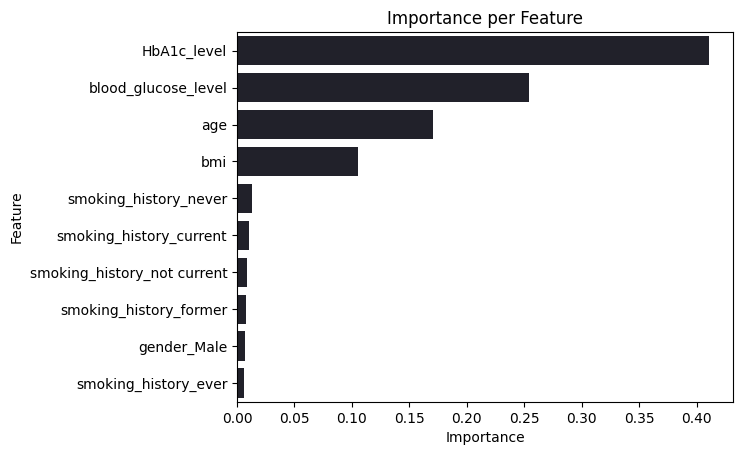

In [112]:
# Visualize our Feature importances

feature_imp_rf = pd.DataFrame(pd.Series(best_RF.estimator.steps[2][1].feature_importances_, index=df_X_train_copy.columns).sort_values(ascending=False))
feature_imp_rf = feature_imp_rf.head(10)
feature_imp_rf['index'] = feature_imp_rf.index
feature_imp_rf.head()

ax = sns.barplot(x=feature_imp_rf[0], y=feature_imp_rf['index'], data=feature_imp_rf, color=pal[0])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Importance per Feature');

#Conclusion

In our diabetes classification problem, we aimed to develop models that could accurately predict the presence of diabetes based on various features. We evaluated the performance of several models, including logistic regression, decision trees, random forest, XGBoost, and MLP neural network.

Overall, our best-performing model for precision was the tuned random forest, achieving a precision score of 100% on both the train and test sets. It demonstrated excellent accuracy in identifying true positive cases of diabetes while minimizing false positives. The decision tree model also achieved high precision scores, but its performance was slightly lower compared to the random forest.

When considering the F1 score, which balances precision and recall, the best decision tree and random forest models showed the highest scores. These models achieved F1 scores of around 80% on the test set, indicating a good balance between precision and recall.

In summary, our models demonstrated strong performance in accurately classifying diabetes cases. The random forest model, with its high precision, and the decision tree model, with a balanced F1 score, show promising potential for accurately predicting diabetes in future applications.

Now that we have a well trained model, we can use it to make predictions on new data.  We were also able to gain insight into what features were the most impactful in the diagnosis of diabetes.  Moving forward we can suggest the following steps to optimize our interventions:
1. Run the algorithm on new data.
2. Continually evole the datasets that are being used for prediction.
3. Try to understand time, and impact of additional metrics in #2 and early diagnosis.
4. Evaluate impact of interventions on classified population vs those that were not classified for programming.
5. Load data into centralized repository for sharing into operational systems.

In [142]:
df_encoded = df_encoded.drop('diabetes', axis=1).copy()

#make predictions on the entire dataset
predictions = best_RF.predict(df_encoded)

#create a new DataFrame with the original data and predicted labels
df_clean['Predicted_Labels'] = predictions

# Save the DataFrame to a CSV file
#result_df.to_csv('predictions.csv', index=False)


KeyError: ignored

In [143]:
df_clean.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,Predicted_Labels
0,Female,80.0,0,1,never,25.19,6.6,140,0,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,0
2,Male,28.0,0,0,never,27.32,5.7,158,0,0
3,Female,36.0,0,0,current,23.45,5.0,155,0,0
4,Male,76.0,1,1,current,20.14,4.8,155,0,0


In [ ]:
#write data back to table in Big Query for further analysis
#import pandas_gbq as gbbq

#set the Google BigQuery project ID, dataset name, and table name
#project_id = 'my-project-id'
#dataset_name = 'my-dataset'
#table_name = 'my-table'

#write the DataFrame to the BigQuery table
#gbbq.to_gbq(df_clean, f'{project_id}.{dataset_name}.{table_name}', if_exists='replace')